# FRAUD DATA SET

## Setup

In [214]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import plot_importance
from sklearn.metrics import roc_curve,precision_recall_curve,RocCurveDisplay,PrecisionRecallDisplay,precision_score,recall_score,ConfusionMatrixDisplay,confusion_matrix
from varclushi import VarClusHi


sys.path.append("../utils")
from utils import supervisado_clasificacion_xgb,supervisado_clasificacion,supervisado_clasificacion_scores,supervisado_clasificacion_redes_neuronales,completitud,supervisado_clasificacion_DecisionTree
sys.path = sys.path[:-1]



pd.options.display.max_columns = 100
pd.options.display.max_rows = 100




## EDA

In [38]:

df = pd.read_csv("../data/ds_challenge_data_2022.csv" ,encoding = "utf-16")


# Tratamiento variable 'dispositivo'
df["dispositivo_año"] = df["dispositivo"].map(lambda x: eval(x)["año"])
df["dispositivo_marca"] = df["dispositivo"].map(lambda x: eval(x)["marca"])
df["dispositivo_proveedor"] = df["dispositivo"].map(lambda x: eval(x)["proveedor"])
df["dispositivo_marca_año"] = df["dispositivo_marca"] + "-" + df["dispositivo_año"].astype(str)


# Tratamiento variables de tiempo 'fecha' y 'hora'
df["fecha"] =df["fecha"] + " " + df["hora"].astype(str)
df["fecha"] = pd.to_datetime(df["fecha"],format = "%d/%m/%y %H")
df = df.sort_values(by = ["user_id","fecha"])
df["diff_hours"] = df.groupby(['user_id'])['fecha'].diff()
df["diff_hours"] = df["diff_hours"].dt.days*24 + df["diff_hours"].dt.seconds/3600


# Convertir bool a int
df["fraude"] = df["fraude"].astype(int)
df["is_prime"] = df["is_prime"].astype(int)
df.drop(columns = ["dispositivo","hora"], inplace = True)


# Generación de varables
df["dispositivo_marca_S_M"] = np.where(df["dispositivo_marca"].isin(["Samsung","Motorola"]),1,0)
df["dispositivo_año_2018"] = np.where(df["dispositivo_año"]<=2018,1,0)
df["ciudad_f"] = np.where(df["ciudad"].isin(["Cancún","Ciudad de México","Monterrey","Tijuana"]),1,0)


### # Transacciones

In [39]:
print(f"Número de transacciones totales: {df.shape[0]}")
print(f"Número de transacciones duplicadas: {df['transaction_id'].duplicated().sum()}")
print(f"Número de transacciones fraudulentas: {df['fraude'].sum()}")
print(f"Porcentaje de transacciones fraudulentas: {df['fraude'].mean().round(4)*100}%")
print(f"Monto promedio por transacción: {df['monto'].mean().round(0)}")
print(f"Desviación estándar por transacción: {df['monto'].std().round(0)}")
print("\n")
print(f"Número de usuarios totales: {df['user_id'].nunique()}")
print(f"Transacciones promedio por usuario: {df.groupby('user_id')['monto'].count().mean().round(0)}")
print(f"Número de usuarios con al menos una transacción fraudulenta: {df.groupby('user_id')['fraude'].max().sum()}")
print(f"Porcentaje de usuarios con al menos una transacción fraudulenta: {df.groupby('user_id')['fraude'].max().mean().round(4)*100}%")
print(f"Monto promedio por usuario: {df.groupby('user_id')['monto'].sum().mean().round(0)}")
print(f"Desviación estándar por usuario: {df.groupby('user_id')['monto'].sum().std().round(0)}")



Número de transacciones totales: 26975
Número de transacciones duplicadas: 0
Número de transacciones fraudulentas: 810
Porcentaje de transacciones fraudulentas: 3.0%
Monto promedio por transacción: 514.0
Desviación estándar por transacción: 290.0


Número de usuarios totales: 4000
Transacciones promedio por usuario: 7.0
Número de usuarios con al menos una transacción fraudulenta: 675
Porcentaje de usuarios con al menos una transacción fraudulenta: 16.88%
Monto promedio por usuario: 3465.0
Desviación estándar por usuario: 3281.0


* **Distribución del tipo de transacción**

In [40]:
df["status_txn"].value_counts(dropna = False)

status_txn
Aceptada      18844
En proceso     5341
Rechazada      2790
Name: count, dtype: int64

In [41]:
df["status_txn"].value_counts(1, dropna = False).round(4)*100

status_txn
Aceptada      69.86
En proceso    19.80
Rechazada     10.34
Name: proportion, dtype: float64

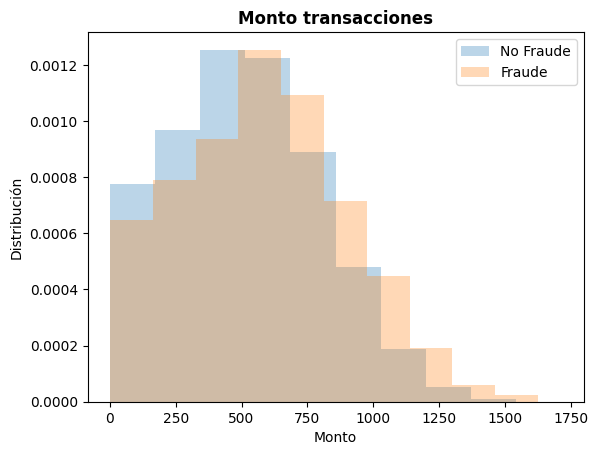

In [42]:
fig, ax = plt.subplots()
ax.hist(df["monto"].loc[df["fraude"]==0],alpha=0.3,label = "No Fraude",density= True)
ax.hist(df["monto"].loc[df["fraude"]==1],alpha=0.3, label = "Fraude",density= True)
ax.set_title('Monto transacciones',fontweight="bold")
ax.set_xlabel("Monto")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()

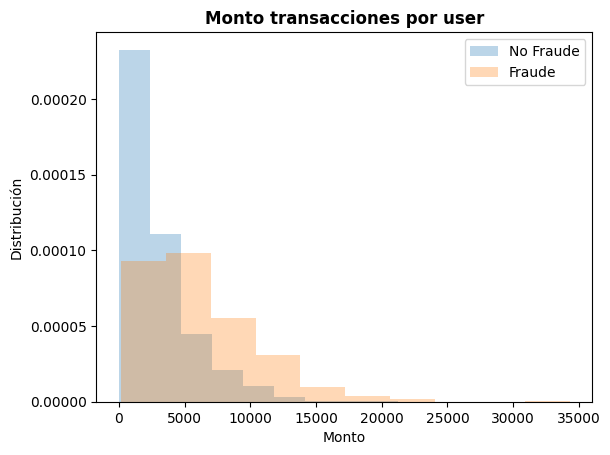

In [43]:
df1 = df.groupby("user_id").agg({"monto":"sum","fraude":"max"})
fig, ax = plt.subplots()
ax.hist(df1["monto"].loc[df1["fraude"]==0],alpha=0.3,label = "No Fraude",density= True)
ax.hist(df1["monto"].loc[df1["fraude"]==1],alpha=0.3, label = "Fraude",density= True)
ax.set_title('Monto transacciones por user',fontweight="bold")
ax.set_xlabel("Monto")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()

### Establecimiento

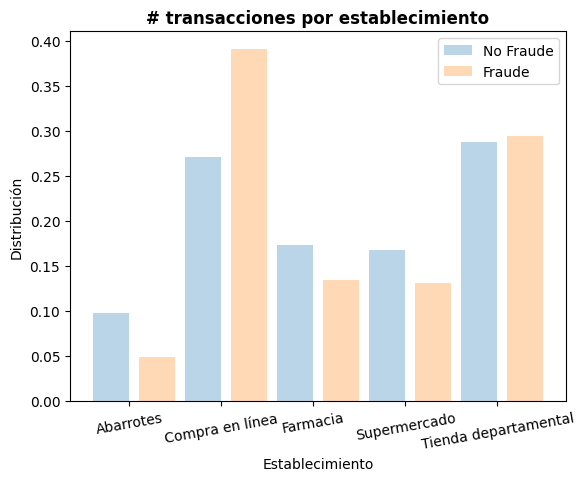

In [44]:
df1 = df.pivot_table(index = "establecimiento", columns = "fraude", values = "transaction_id", aggfunc = "count")
df1 = df1/df1.sum()
fig, ax = plt.subplots()
ax.bar(np.arange(len(df1))-0.2,df1[0],label = "No Fraude",width=0.4,alpha = 0.3)
ax.bar(np.arange(len(df1))+0.3,df1[1],label = "Fraude",width=0.4,alpha = 0.3)
ax.set_xticks(np.arange(len(df1)),df1.index,rotation = 10)
ax.set_title('# transacciones por establecimiento',fontweight="bold")
ax.set_xlabel("Establecimiento")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()



### Ciudad

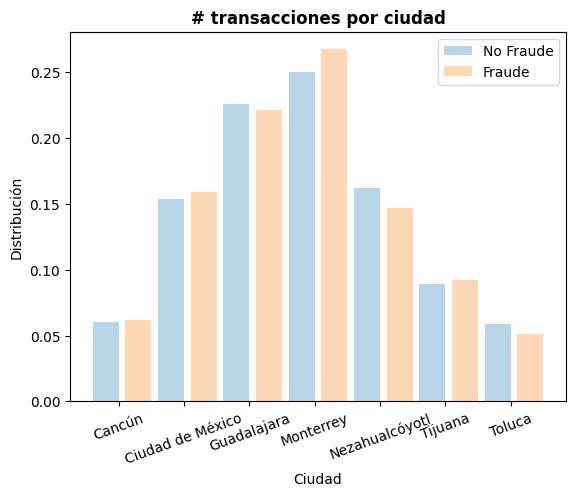

In [45]:
df1 = df.pivot_table(index = "ciudad", columns = "fraude", values = "transaction_id", aggfunc = "count")
df1 = df1/df1.sum()
fig, ax = plt.subplots()
ax.bar(np.arange(len(df1))-0.2,df1[0],label = "No Fraude",width=0.4,alpha = 0.3)
ax.bar(np.arange(len(df1))+0.3,df1[1],label = "Fraude",width=0.4,alpha = 0.3)
ax.set_xticks(np.arange(len(df1)),df1.index,rotation = 20)
ax.set_title('# transacciones por ciudad',fontweight="bold")
ax.set_xlabel("Ciudad")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()



### Dispositivo

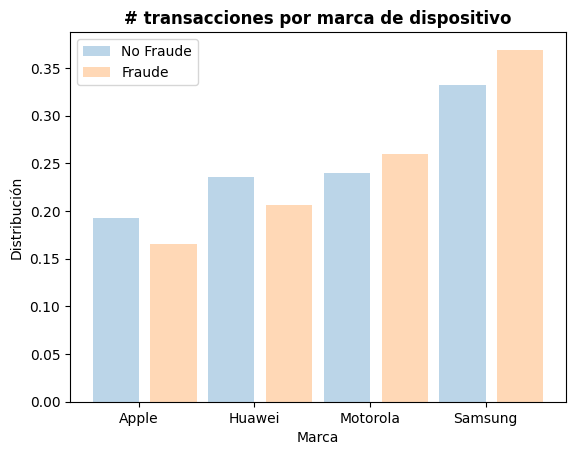

In [46]:
df1 = df.pivot_table(index = "dispositivo_marca", columns = "fraude", values = "transaction_id", aggfunc = "count")
df1 = df1/df1.sum()
fig, ax = plt.subplots()
ax.bar(np.arange(len(df1))-0.2,df1[0],label = "No Fraude",width=0.4,alpha = 0.3)
ax.bar(np.arange(len(df1))+0.3,df1[1],label = "Fraude",width=0.4,alpha = 0.3)
ax.set_xticks(np.arange(len(df1)),df1.index,rotation = 0)
ax.set_title('# transacciones por marca de dispositivo',fontweight="bold")
ax.set_xlabel("Marca")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()



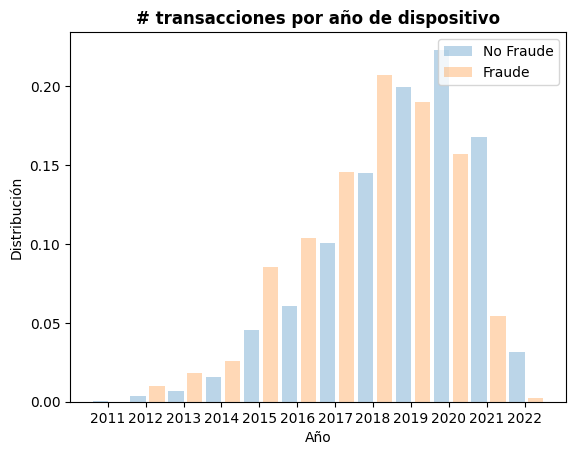

In [47]:
df1 = df.pivot_table(index = "dispositivo_año", columns = "fraude", values = "transaction_id", aggfunc = "count")
df1 = df1/df1.sum()
fig, ax = plt.subplots()
ax.bar(np.arange(len(df1))-0.2,df1[0],label = "No Fraude",width=0.4,alpha = 0.3)
ax.bar(np.arange(len(df1))+0.3,df1[1],label = "Fraude",width=0.4,alpha = 0.3)
ax.set_xticks(np.arange(len(df1)),df1.index,rotation = 0)
ax.set_title('# transacciones por año de dispositivo',fontweight="bold")
ax.set_xlabel("Año")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()


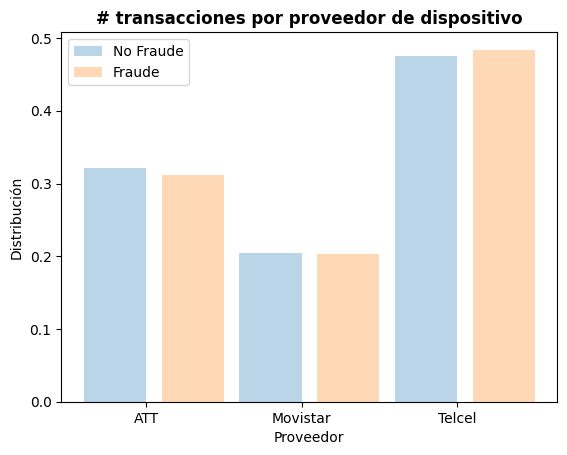

In [48]:
df1 = df.pivot_table(index = "dispositivo_proveedor", columns = "fraude", values = "transaction_id", aggfunc = "count")
df1 = df1/df1.sum()
fig, ax = plt.subplots()
ax.bar(np.arange(len(df1))-0.2,df1[0],label = "No Fraude",width=0.4,alpha = 0.3)
ax.bar(np.arange(len(df1))+0.3,df1[1],label = "Fraude",width=0.4,alpha = 0.3)
ax.set_xticks(np.arange(len(df1)),df1.index,rotation = 0)
ax.set_title('# transacciones por proveedor de dispositivo',fontweight="bold")
ax.set_xlabel("Proveedor")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()


### Tipo de transacción

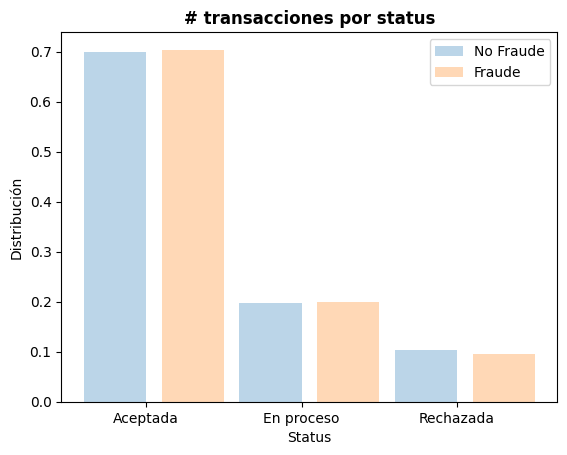

In [49]:
df1 = df.pivot_table(index = "status_txn", columns = "fraude", values = "transaction_id", aggfunc = "count")
df1 = df1/df1.sum()
fig, ax = plt.subplots()
ax.bar(np.arange(len(df1))-0.2,df1[0],label = "No Fraude",width=0.4,alpha = 0.3)
ax.bar(np.arange(len(df1))+0.3,df1[1],label = "Fraude",width=0.4,alpha = 0.3)
ax.set_xticks(np.arange(len(df1)),df1.index,rotation = 0)
ax.set_title('# transacciones por status',fontweight="bold")
ax.set_xlabel("Status")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()


## Preprocessing

In [185]:
df_user = df.groupby(
    ["user_id","género","linea_tc","interes_tc","is_prime"]
).agg(
    {
        "transaction_id":"count"
        ,"dispositivo_marca_año": "nunique"
        ,"dispositivo_proveedor": "nunique"
        ,"dispositivo_marca_S_M":"max"
        ,"dispositivo_año_2018":"max"
        ,"establecimiento": "nunique"
        ,"ciudad":"nunique"
        ,"ciudad_f":"max"
        ,"diff_hours": ["mean","std","min","max",pd.DataFrame.kurtosis]
        ,"fraude": "max"
    }
).reset_index().rename(
    columns = {
        "transaction_id":"transactions_total"
        ,"dispositivo_marca_año":"num_dispositivos"
        ,"dispositivo_proveedor":"num_proveedores"
        ,"establecimiento":"num_establecimientos"
        ,"ciudad":"num_ciudades"
        ,"fraude":"target"
    }
)
df_user.columns = [x[0]+"_"+x[1] if x[0] in ["diff_hours"] else x[0] for x in df_user.columns]



for i,status in enumerate(["Aceptada","En proceso","Rechazada"]):
    df_aux = df.loc[df["status_txn"]==status].groupby(["user_id"]).agg(
        {
            "monto": ["count","sum","mean","std","min","max",pd.DataFrame.kurtosis]
            ,"dcto": ["count","sum","mean","std","min","max",pd.DataFrame.kurtosis]
            ,"cashback": ["count","sum","mean","std","min","max",pd.DataFrame.kurtosis]
        }
    )
    df_aux.columns = [x[0]+"_"+x[1]+"_"+status for x in df_aux.columns]
    df_user = df_user.merge(df_aux.reset_index(), on ="user_id", how = "left")
    for j in [x for x in df_aux.columns if "std" not in x and "kurt" not in x]:
        df_user[j] = df_user[j].fillna(0)

    
    
df_aux = df.copy()
df_aux["establecimiento"] = df_aux["establecimiento"].replace({np.nan: "No definido"})
est = df_aux["establecimiento"].unique()
df_aux = pd.get_dummies(df_aux, columns =["establecimiento"], drop_first = False)
df_aux =  df_aux.groupby(["user_id"]).agg(dict(zip(["establecimiento"+"_"+x for x in est], ["mean"]*len(est))))
df_user = df_user.merge(df_aux.reset_index(), on ="user_id", how = "left")



df_user["género_M"] = np.where(df_user["género"]=="M",1,0)
df_user["género_F"] = np.where(df_user["género"]=="F",1,0)
df_user.drop(columns = "género",inplace= True)
    

print(df_user.shape)
df_user[df_user.duplicated(subset = "user_id",keep=False)].sort_values(by = "user_id")




(4000, 89)


Empty DataFrame
Columns: [user_id, linea_tc, interes_tc, is_prime, transactions_total, num_dispositivos, num_proveedores, dispositivo_marca_S_M, dispositivo_año_2018, num_establecimientos, num_ciudades, ciudad_f, diff_hours_mean, diff_hours_std, diff_hours_min, diff_hours_max, diff_hours_kurt, target, monto_count_Aceptada, monto_sum_Aceptada, monto_mean_Aceptada, monto_std_Aceptada, monto_min_Aceptada, monto_max_Aceptada, monto_kurt_Aceptada, dcto_count_Aceptada, dcto_sum_Aceptada, dcto_mean_Aceptada, dcto_std_Aceptada, dcto_min_Aceptada, dcto_max_Aceptada, dcto_kurt_Aceptada, cashback_count_Aceptada, cashback_sum_Aceptada, cashback_mean_Aceptada, cashback_std_Aceptada, cashback_min_Aceptada, cashback_max_Aceptada, cashback_kurt_Aceptada, monto_count_En proceso, monto_sum_En proceso, monto_mean_En proceso, monto_std_En proceso, monto_min_En proceso, monto_max_En proceso, monto_kurt_En proceso, dcto_count_En proceso, dcto_sum_En proceso, dcto_mean_En proceso, dcto_std_En proceso, dcto_min_En proceso, dcto_max_En proceso, dcto_kurt_En proceso, cashback_count_En proceso, cashback_sum_En proceso, cashback_mean_En proceso, cashback_std_En proceso, cashback_min_En proceso, cashback_max_En proceso, cashback_kurt_En proceso, monto_count_Rechazada, monto_sum_Rechazada, monto_mean_Rechazada, monto_std_Rechazada, monto_min_Rechazada, monto_max_Rechazada, monto_kurt_Rechazada, dcto_count_Rechazada, dcto_sum_Rechazada, dcto_mean_Rechazada, dcto_std_Rechazada, dcto_min_Rechazada, dcto_max_Rechazada, dcto_kurt_Rechazada, cashback_count_Rechazada, cashback_sum_Rechazada, cashback_mean_Rechazada, cashback_std_Rechazada, cashback_min_Rechazada, cashback_max_Rechazada, cashback_kurt_Rechazada, establecimiento_Tienda departamental, establecimiento_Compra en línea, establecimiento_Farmacia, establecimiento_Supermercado, establecimiento_No definido, establecimiento_Abarrotes, género_M, género_F]
Index: []

In [186]:
comp = completitud(df_user)
comp

df  completitud  missings     type   
0                                user_id      100.000         0    int64  \
1                               linea_tc      100.000         0    int64   
2                             interes_tc      100.000         0    int64   
3                               is_prime      100.000         0    int64   
4                     transactions_total      100.000         0    int64   
5                       num_dispositivos      100.000         0    int64   
6                        num_proveedores      100.000         0    int64   
7                  dispositivo_marca_S_M      100.000         0    int64   
8                   dispositivo_año_2018      100.000         0    int64   
9                   num_establecimientos      100.000         0    int64   
10                          num_ciudades      100.000         0    int64   
11                              ciudad_f      100.000         0    int64   
12                       diff_hours_mean       85.800       568  float64   
13                        diff_hours_std       72.725      1091  float64   
14                        diff_hours_min       85.800       568  float64   
15                        diff_hours_max       85.800       568  float64   
16                       diff_hours_kurt       52.225      1911  float64   
17                                target      100.000         0    int64   
18                  monto_count_Aceptada      100.000         0  float64   
19                    monto_sum_Aceptada      100.000         0  float64   
20                   monto_mean_Aceptada      100.000         0  float64   
21                    monto_std_Aceptada       76.025       959  float64   
22                    monto_min_Aceptada      100.000         0  float64   
23                    monto_max_Aceptada      100.000         0  float64   
24                   monto_kurt_Aceptada       47.875      2085  float64   
25                   dcto_count_Aceptada      100.000         0  float64   
26                     dcto_sum_Aceptada      100.000         0  float64   
27                    dcto_mean_Aceptada      100.000         0  float64   
28                     dcto_std_Aceptada       76.025       959  float64   
29                     dcto_min_Aceptada      100.000         0  float64   
30                     dcto_max_Aceptada      100.000         0  float64   
31                    dcto_kurt_Aceptada       47.875      2085  float64   
32               cashback_count_Aceptada      100.000         0  float64   
33                 cashback_sum_Aceptada      100.000         0  float64   
34                cashback_mean_Aceptada      100.000         0  float64   
35                 cashback_std_Aceptada       76.025       959  float64   
36                 cashback_min_Aceptada      100.000         0  float64   
37                 cashback_max_Aceptada      100.000         0  float64   
38                cashback_kurt_Aceptada       47.875      2085  float64   
39                monto_count_En proceso      100.000         0  float64   
40                  monto_sum_En proceso      100.000         0  float64   
41                 monto_mean_En proceso      100.000         0  float64   
42                  monto_std_En proceso       33.475      2661  float64   
43                  monto_min_En proceso      100.000         0  float64   
44                  monto_max_En proceso      100.000         0  float64   
45                 monto_kurt_En proceso        8.775      3649  float64   
46                 dcto_count_En proceso      100.000         0  float64   
47                   dcto_sum_En proceso      100.000         0  float64   
48                  dcto_mean_En proceso      100.000         0  float64   
49                   dcto_std_En proceso       33.475      2661  float64   
50                   dcto_min_En proceso      100.000         0  float64   
51                   dcto_max_En proceso      100.000         0  float64   
52        

In [187]:
df_user = df_user[[x for x in df_user.columns if x not in comp.loc[comp["completitud"]<80,"df"].to_list()]].copy()
print(len(comp.loc[comp["completitud"]<80,"df"].to_list()))

20


### Train test split

In [53]:

X = df_user.copy()
y = X[["target"]]
X = X.drop(columns = ["user_id","target"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 230522)   
X1_train = X_train.copy()
y1_train = y_train.copy()



### Outliers

* **SÓLO APLICA PARA REGRESIÓN LOGÍSTICA**

In [54]:
cols = X1_train.columns
for campo in cols:
    Q1=X1_train[campo].quantile(0.01)
    Q3=X1_train[campo].quantile(0.99)
    IQR=Q3-Q1
    INF=Q1#-1.5*(IQR)
    SUP=Q3#+1.5*(IQR)
    X1_train[campo+"_outliers"]=X1_train[campo].map(lambda x:1 if (x<INF) | (x>SUP) else 0)
    
x_train=X1_train.shape[0]
columnas_train=["Inicial"]
rows_train=[X1_train.shape[0]]
porcentaje_train=[X1_train.shape[0]/x_train]

for campo in cols:
    
    columnas_train.extend([campo])
    rows_train.extend([X1_train[X1_train[campo+"_outliers"]==0].shape[0]])
    porcentaje_train.extend([X1_train[X1_train[campo+"_outliers"]==0].shape[0]/x_train])
    y1_train=y1_train.loc[X1_train[X1_train[campo+"_outliers"]==0].index.values]
    X1_train=X1_train[X1_train[campo+"_outliers"]==0]
    
for campo in cols:
    X1_train.drop(columns=[campo+"_outliers"],inplace=True)

outliers_train=pd.DataFrame({"columnas_train":columnas_train,"rows_train":rows_train,"porcentaje_train":porcentaje_train})
outliers_train

columnas_train  rows_train  porcentaje_train
0                                Inicial        2800          1.000000
1                               linea_tc        2800          1.000000
2                             interes_tc        2800          1.000000
3                               is_prime        2800          1.000000
4                     transactions_total        2776          0.991429
5                       num_dispositivos        2758          0.985000
6                        num_proveedores        2758          0.985000
7                  dispositivo_marca_S_M        2758          0.985000
8                   dispositivo_año_2018        2758          0.985000
9                   num_establecimientos        2758          0.985000
10                          num_ciudades        2744          0.980000
11                              ciudad_f        2744          0.980000
12                       diff_hours_mean        2701          0.964643
13                        diff_hours_min        2701          0.964643
14                        diff_hours_max        2687          0.959643
15                  monto_count_Aceptada        2681          0.957500
16                    monto_sum_Aceptada        2673          0.954643
17                   monto_mean_Aceptada        2646          0.945000
18                    monto_min_Aceptada        2641          0.943214
19                    monto_max_Aceptada        2620          0.935714
20                   dcto_count_Aceptada        2620          0.935714
21                     dcto_sum_Aceptada        2601          0.928929
22                    dcto_mean_Aceptada        2582          0.922143
23                     dcto_min_Aceptada        2580          0.921429
24                     dcto_max_Aceptada        2560          0.914286
25               cashback_count_Aceptada        2560          0.914286
26                 cashback_sum_Aceptada        2556          0.912857
27                cashback_mean_Aceptada        2538          0.906429
28                 cashback_min_Aceptada        2532          0.904286
29                 cashback_max_Aceptada        2513          0.897500
30                monto_count_En proceso        2504          0.894286
31                  monto_sum_En proceso        2499          0.892500
32                 monto_mean_En proceso        2472          0.882857
33                  monto_min_En proceso        2471          0.882500
34                  monto_max_En proceso        2457          0.877500
35                 dcto_count_En proceso        2457          0.877500
36                   dcto_sum_En proceso        2446          0.873571
37                  dcto_mean_En proceso        2425          0.866071
38                   dcto_min_En proceso        2424          0.865714
39                   dcto_max_En proceso        2414          0.862143
40             cashback_count_En proceso        2414          0.862143
41               cashback_sum_En proceso        2414          0.862143
42              cashback_mean_En proceso        2396          0.855714
43               cashback_min_En proceso        2394          0.855000
44               cashback_max_En proceso        2384          0.851429
45                 monto_count_Rechazada        2368          0.845714
46                   monto_sum_Rechazada        2360          0.842857
47                  monto_mean_Rechazada        2336          0.834286
48                   monto_min_Rechazada        2334          0.833571
49                   monto_max_Rechazada        2325          0.830357
50                  dcto_count_Rechazada        2325          0.830357
51                    dcto_sum_Rechazada        2317          0.827500
52                   dcto_mean_Rechazada        2297          0.820357
53                    dcto_min_Rechazada        2297          0.820357
54                    dcto_max_Rechazada        2288          0.817143
55              cashback_count_Rechazada        22

### Correlación

In [64]:
df_aux = X_train[X_train.isnull().sum(axis=1)==0]
vif = pd.DataFrame()
vif["variables"] = df_aux.columns
vif["VIF"] = [variance_inflation_factor(df_aux.values, i) for i in range(df_aux.shape[1])]
vif=vif.sort_values(by="VIF",ascending=False)
vif

divide by zero encountered in scalar divide


variables          VIF
29                monto_count_En proceso          inf
54              cashback_count_Rechazada          inf
19                   dcto_count_Aceptada          inf
39             cashback_count_En proceso          inf
14                  monto_count_Aceptada          inf
24               cashback_count_Aceptada          inf
44                 monto_count_Rechazada          inf
49                  dcto_count_Rechazada          inf
3                     transactions_total          inf
34                 dcto_count_En proceso          inf
46                  monto_mean_Rechazada  1020.060198
56               cashback_mean_Rechazada   677.339948
31                 monto_mean_En proceso   301.883366
47                   monto_min_Rechazada   289.705633
41              cashback_mean_En proceso   287.479498
48                   monto_max_Rechazada   281.359096
55                cashback_sum_Rechazada   228.484206
57                cashback_min_Rechazada   221.966826
45                   monto_sum_Rechazada   213.101938
58                cashback_max_Rechazada   209.812873
40               cashback_sum_En proceso   200.178653
30                  monto_sum_En proceso   198.676768
15                    monto_sum_Aceptada   198.608724
25                 cashback_sum_Aceptada   183.004012
42               cashback_min_En proceso   102.928237
32                  monto_min_En proceso    99.739503
43               cashback_max_En proceso    96.078282
33                  monto_max_En proceso    94.706391
51                   dcto_mean_Rechazada    82.658464
36                  dcto_mean_En proceso    39.115454
53                    dcto_max_Rechazada    35.444044
16                   monto_mean_Aceptada    29.402138
11                       diff_hours_mean    29.343752
17                    monto_min_Aceptada    28.801749
27                 cashback_min_Aceptada    26.364852
52                    dcto_min_Rechazada    24.266811
26                cashback_mean_Aceptada    23.138104
38                   dcto_max_En proceso    23.044082
50                    dcto_sum_Rechazada    22.111972
12                        diff_hours_min    13.919015
35                   dcto_sum_En proceso    13.213969
37                   dcto_min_En proceso    11.454711
59  establecimiento_Tienda departamental    11.072984
28                 cashback_max_Aceptada    10.840841
60       establecimiento_Compra en línea    10.664756
18                    monto_max_Aceptada    10.480638
21                    dcto_mean_Aceptada     8.571098
23                     dcto_max_Aceptada     7.354357
13                        diff_hours_max     6.652797
61              establecimiento_Farmacia     6.236179
62          establecimiento_Supermercado     6.070459
20                     dcto_sum_Aceptada     6.009140
63           establecimiento_No definido     4.325926
64             establecimiento_Abarrotes     3.706701
66                              género_F     3.550371
65                              género_M     3.546659
8                   num_establecimientos     3.422329
4                       num_dispositivos     3.291987
5                        num_proveedores     2.587049
22                     dcto_min_Aceptada     2.537032
9                           num_ciudades     1.538814
7                   dispositivo_año_2018     1.157286
10                              ciudad_f     1.125447
6                  dispositivo_marca_S_M     1.107161
1                             interes_tc     1.027233
2                               is_prime     1.020506
0                               linea_tc     1.019503

In [107]:
vc = VarClusHi(df=df_aux,feat_list=df_aux.columns,maxeigval2=0.4)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
c_best = rs.loc[rs['id']==1]['Variable'].tolist()
c_best

['monto_count_Aceptada',
 'monto_count_Rechazada',
 'monto_count_En proceso',
 'monto_min_Aceptada',
 'cashback_max_En proceso',
 'dcto_sum_Rechazada',
 'dcto_max_En proceso',
 'cashback_mean_Rechazada',
 'género_F',
 'diff_hours_min',
 'num_proveedores',
 'dcto_min_Aceptada',
 'dcto_sum_Aceptada',
 'establecimiento_Tienda departamental',
 'establecimiento_Abarrotes',
 'ciudad_f',
 'establecimiento_Compra en línea',
 'is_prime',
 'interes_tc',
 'linea_tc',
 'establecimiento_Supermercado',
 'cashback_max_Aceptada',
 'dcto_min_En proceso',
 'dispositivo_marca_S_M',
 'establecimiento_Farmacia',
 'dispositivo_año_2018',
 'establecimiento_No definido',
 'monto_mean_Aceptada',
 'num_ciudades',
 'cashback_min_En proceso',
 'dcto_min_Rechazada',
 'diff_hours_max',
 'num_establecimientos',
 'dcto_mean_Aceptada']

In [173]:
vc.info

Cluster N_Vars   Eigval1   Eigval2   VarProp
0        0      6  5.812671  0.123167  0.968778
1        1      5  4.728791  0.247792  0.945758
2        2      5  4.774121  0.206073  0.954824
3        3      2  1.967385  0.032615  0.983692
4        4      4  3.710621  0.145131  0.927655
5        5      2  1.967941  0.032059  0.983970
6        6      3  2.722114  0.236138  0.907371
7        7      6  5.505389  0.347121  0.917565
8        8      2  1.843832  0.156168  0.921916
9        9      2  1.897414  0.102586  0.948707
10      10      2  1.773343  0.226657  0.886672
11      11      1  1.000000  0.000000  1.000000
12      12      2  1.836350  0.163650  0.918175
13      13      1  1.000000  0.000000  1.000000
14      14      1  1.000000  0.000000  1.000000
15      15      1  1.000000  0.000000  1.000000
16      16      1  1.000000  0.000000  1.000000
17      17      1  1.000000  0.000000  1.000000
18      18      1  1.000000  0.000000  1.000000
19      19      1  1.000000  0.000000  1.000000
20      20      1  1.000000  0.000000  1.000000
21      21      2  1.761709  0.238291  0.880854
22      22      1  1.000000  0.000000  1.000000
23      23      1  1.000000  0.000000  1.000000
24      24      1  1.000000  0.000000  1.000000
25      25      1  1.000000  0.000000  1.000000
26      26      1  1.000000  0.000000  1.000000
27      27      2  1.899356  0.100644  0.949678
28      28      1  1.000000  0.000000  1.000000
29      29      2  1.938523  0.061477  0.969262
30      30      2  1.884815  0.115185  0.942407
31      31      1  1.000000  0.000000  1.000000
32      32      1  1.000000  0.000000  1.000000
33      33      1  1.000000  0.000000  1.000000

### Feature selection

In [116]:
modelo_xgb = supervisado_clasificacion_xgb(
    X_entrenamiento=X_train[c_best],
    y_entrenamiento=y_train,
    X_prueba=X_test[c_best],
    y_prueba=y_test,
    semilla=230522,
    folds_search=3,
    folds_CV=10,
    iteraciones=0.00005,
    score="roc_auc",
    param_grid = {
        "n_estimators" : [x for x in range(50,2000,50)],
        "max_depth" : [x for x in range(3,21)],
        'learning_rate': [x/50 for x in range(1,15,1)],
        "alpha":[x for x in range(2,21,1)],
        "lambda":[x for x in range(2,21,1)],
        "random_state": [230522],
        "scale_pos_weight": [sum(y_train[y_train.columns[0]]==0)/sum(y_train[y_train.columns[0]]==1)]
    }
)
#4:39

Fitting 3 folds for each of 178 candidates, totalling 534 fits
[CV 1/3] END alpha=5, lambda=16, learning_rate=0.1, max_depth=20, n_estimators=350, random_state=230522, scale_pos_weight=4.870020964360587;, score=0.803 total time=   4.0s
[CV 3/3] END alpha=5, lambda=20, learning_rate=0.16, max_depth=18, n_estimators=300, random_state=230522, scale_pos_weight=4.870020964360587;, score=0.747 total time=   2.7s
[CV 3/3] END alpha=2, lambda=15, learning_rate=0.2, max_depth=18, n_estimators=450, random_state=230522, scale_pos_weight=4.870020964360587;, score=0.737 total time=   3.3s
[CV 3/3] END alpha=17, lambda=6, learning_rate=0.22, max_depth=14, n_estimators=850, random_state=230522, scale_pos_weight=4.870020964360587;, score=0.755 total time=   1.8s
[CV 2/3] END alpha=17, lambda=3, learning_rate=0.04, max_depth=12, n_estimators=850, random_state=230522, scale_pos_weight=4.870020964360587;, score=0.756 total time=   3.7s
[CV 3/3] END alpha=4, lambda=15, learning_rate=0.18, max_depth=3, n_e

In [117]:
modelo_xgb["tabla_scores"]

modelo  score_searched       roc  score_mean_cross_val   
0  xgb_classifier        0.791671  0.775409              0.796345  \

   score_std_cross_val  accuracy        F1                confusion        ks   
0              0.04119  0.734167  0.412523  [[769, 233], [86, 112]]  0.438063  \

        thr  
0  0.515575

In [119]:
min_features_to_select = 10
rfecv = RFECV(
    estimator=modelo_xgb["xgb_classifier"]["parametros"],
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
    n_jobs=4,
)
rfecv.fit(X_train[c_best], y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(alpha=19, base_score=None, booster=None,
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, lambda=3,
                              learning_rate=0.16, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1600,
                              n_jobs=None, num_parallel_tree=None, ...),
      min_features_to_select=10, n_jobs=4, scoring='roc_auc')

In [120]:
print(f"Número de features seleccionadas: {rfecv.n_features_}")

Número de features seleccionadas: 13


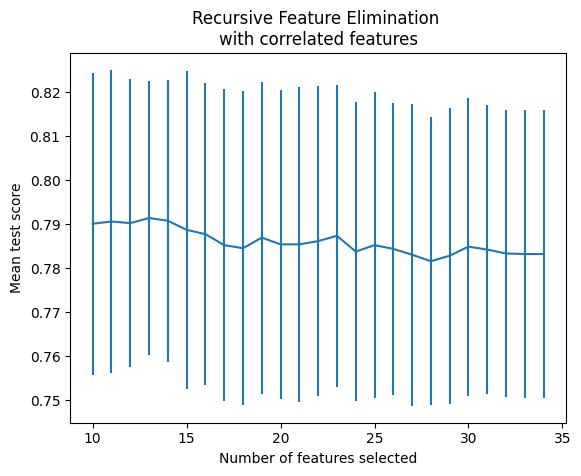

In [121]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [122]:
df_features = pd.DataFrame(zip(rfecv.feature_names_in_,rfecv.ranking_),columns = ["feature","rank"]).sort_values(by = "rank", ascending = True)
df_features.head(20)

feature  rank
0                   monto_count_Aceptada     1
31                        diff_hours_max     1
29               cashback_min_En proceso     1
28                          num_ciudades     1
27                   monto_mean_Aceptada     1
25                  dispositivo_año_2018     1
21                 cashback_max_Aceptada     1
20          establecimiento_Supermercado     1
18                            interes_tc     1
13  establecimiento_Tienda departamental     1
16       establecimiento_Compra en línea     1
7                cashback_mean_Rechazada     1
4                cashback_max_En proceso     1
24              establecimiento_Farmacia     2
9                         diff_hours_min     3
26           establecimiento_No definido     4
15                              ciudad_f     5
12                     dcto_sum_Aceptada     6
5                     dcto_sum_Rechazada     7
19                              linea_tc     8

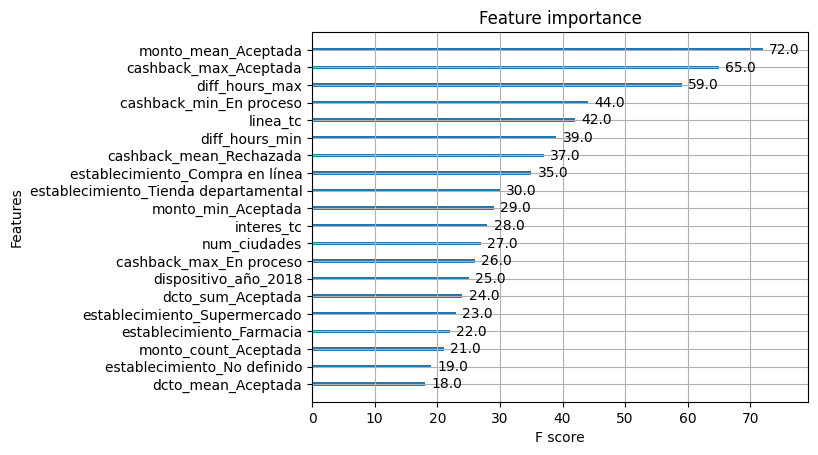

In [123]:
plot_importance(modelo_xgb["xgb_classifier"]["parametros"],max_num_features=20);

In [124]:
df_features.loc[df_features["rank"]==1,"feature"].to_list()

['monto_count_Aceptada',
 'diff_hours_max',
 'cashback_min_En proceso',
 'num_ciudades',
 'monto_mean_Aceptada',
 'dispositivo_año_2018',
 'cashback_max_Aceptada',
 'establecimiento_Supermercado',
 'interes_tc',
 'establecimiento_Tienda departamental',
 'establecimiento_Compra en línea',
 'cashback_mean_Rechazada',
 'cashback_max_En proceso']

In [126]:
features = [
    'monto_count_Aceptada','diff_hours_max','cashback_min_En proceso','num_ciudades','monto_mean_Aceptada',
    'dispositivo_año_2018','cashback_max_Aceptada','establecimiento_Supermercado','interes_tc','establecimiento_Tienda departamental',
    'establecimiento_Compra en línea','cashback_mean_Rechazada','cashback_max_En proceso'
]



In [191]:
df_aux = X_train[X_train.isnull().sum(axis=1)==0][features]
vif = pd.DataFrame()
vif["variables"] = df_aux.columns
vif["VIF"] = [variance_inflation_factor(df_aux.values, i) for i in range(df_aux.shape[1])]
vif=vif.sort_values(by="VIF",ascending=False)
vif

variables        VIF
8                             interes_tc  14.608973
4                    monto_mean_Aceptada  12.531540
6                  cashback_max_Aceptada  10.250043
3                           num_ciudades   6.906425
0                   monto_count_Aceptada   5.058921
1                         diff_hours_max   4.944766
12               cashback_max_En proceso   4.784691
2                cashback_min_En proceso   3.325038
10       establecimiento_Compra en línea   2.959949
9   establecimiento_Tienda departamental   2.934172
5                   dispositivo_año_2018   2.139942
7           establecimiento_Supermercado   1.972621
11               cashback_mean_Rechazada   1.699275

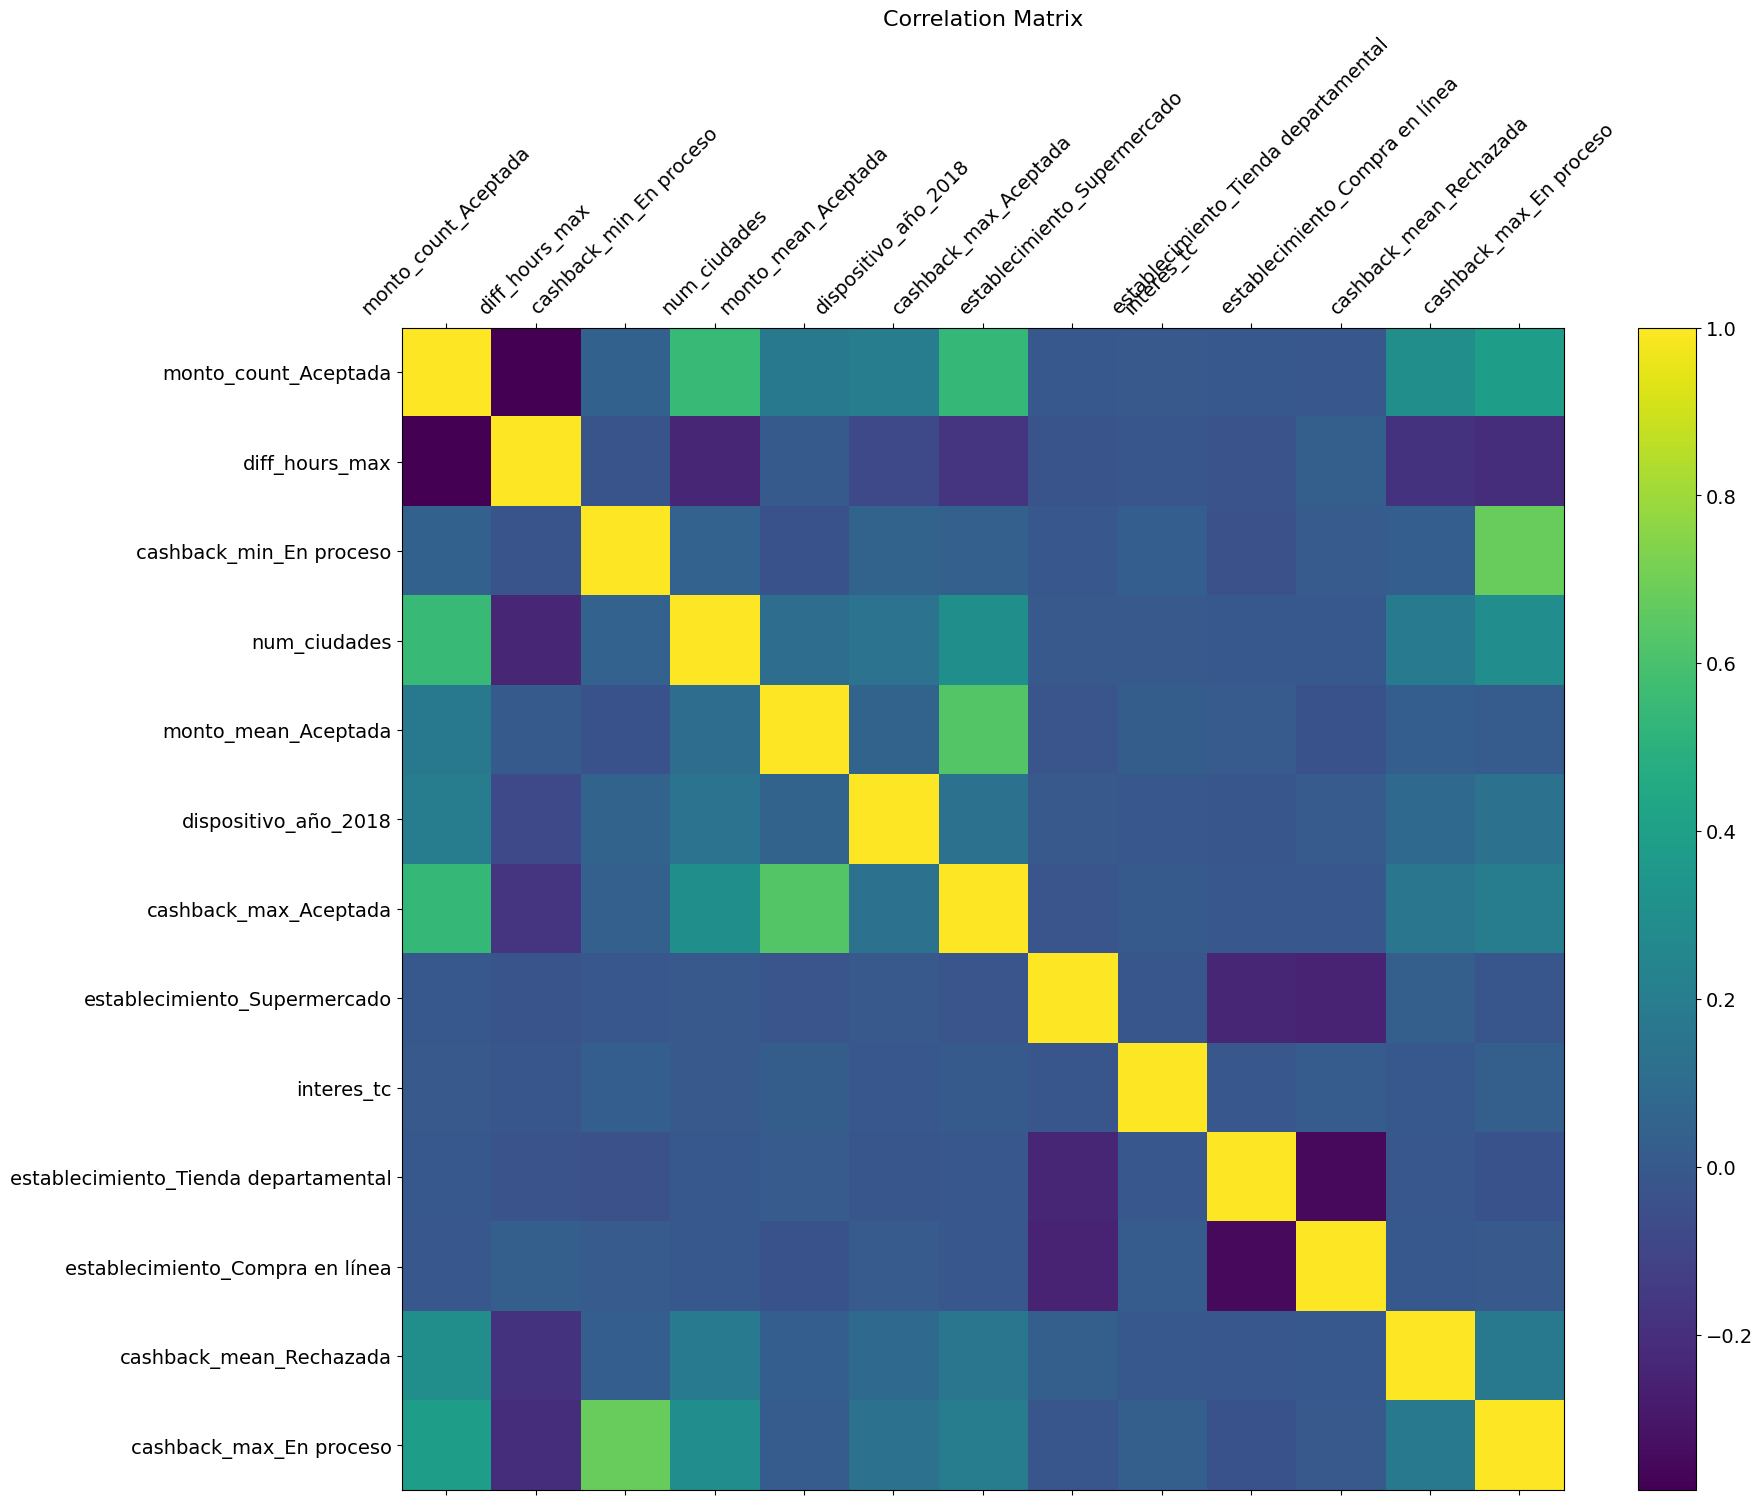

In [192]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train[features].corr(), fignum=f.number)
plt.xticks(range(X_train[features].select_dtypes(['number']).shape[1]), X_train[features].select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X_train[features].select_dtypes(['number']).shape[1]), X_train[features].select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Distribución features finales


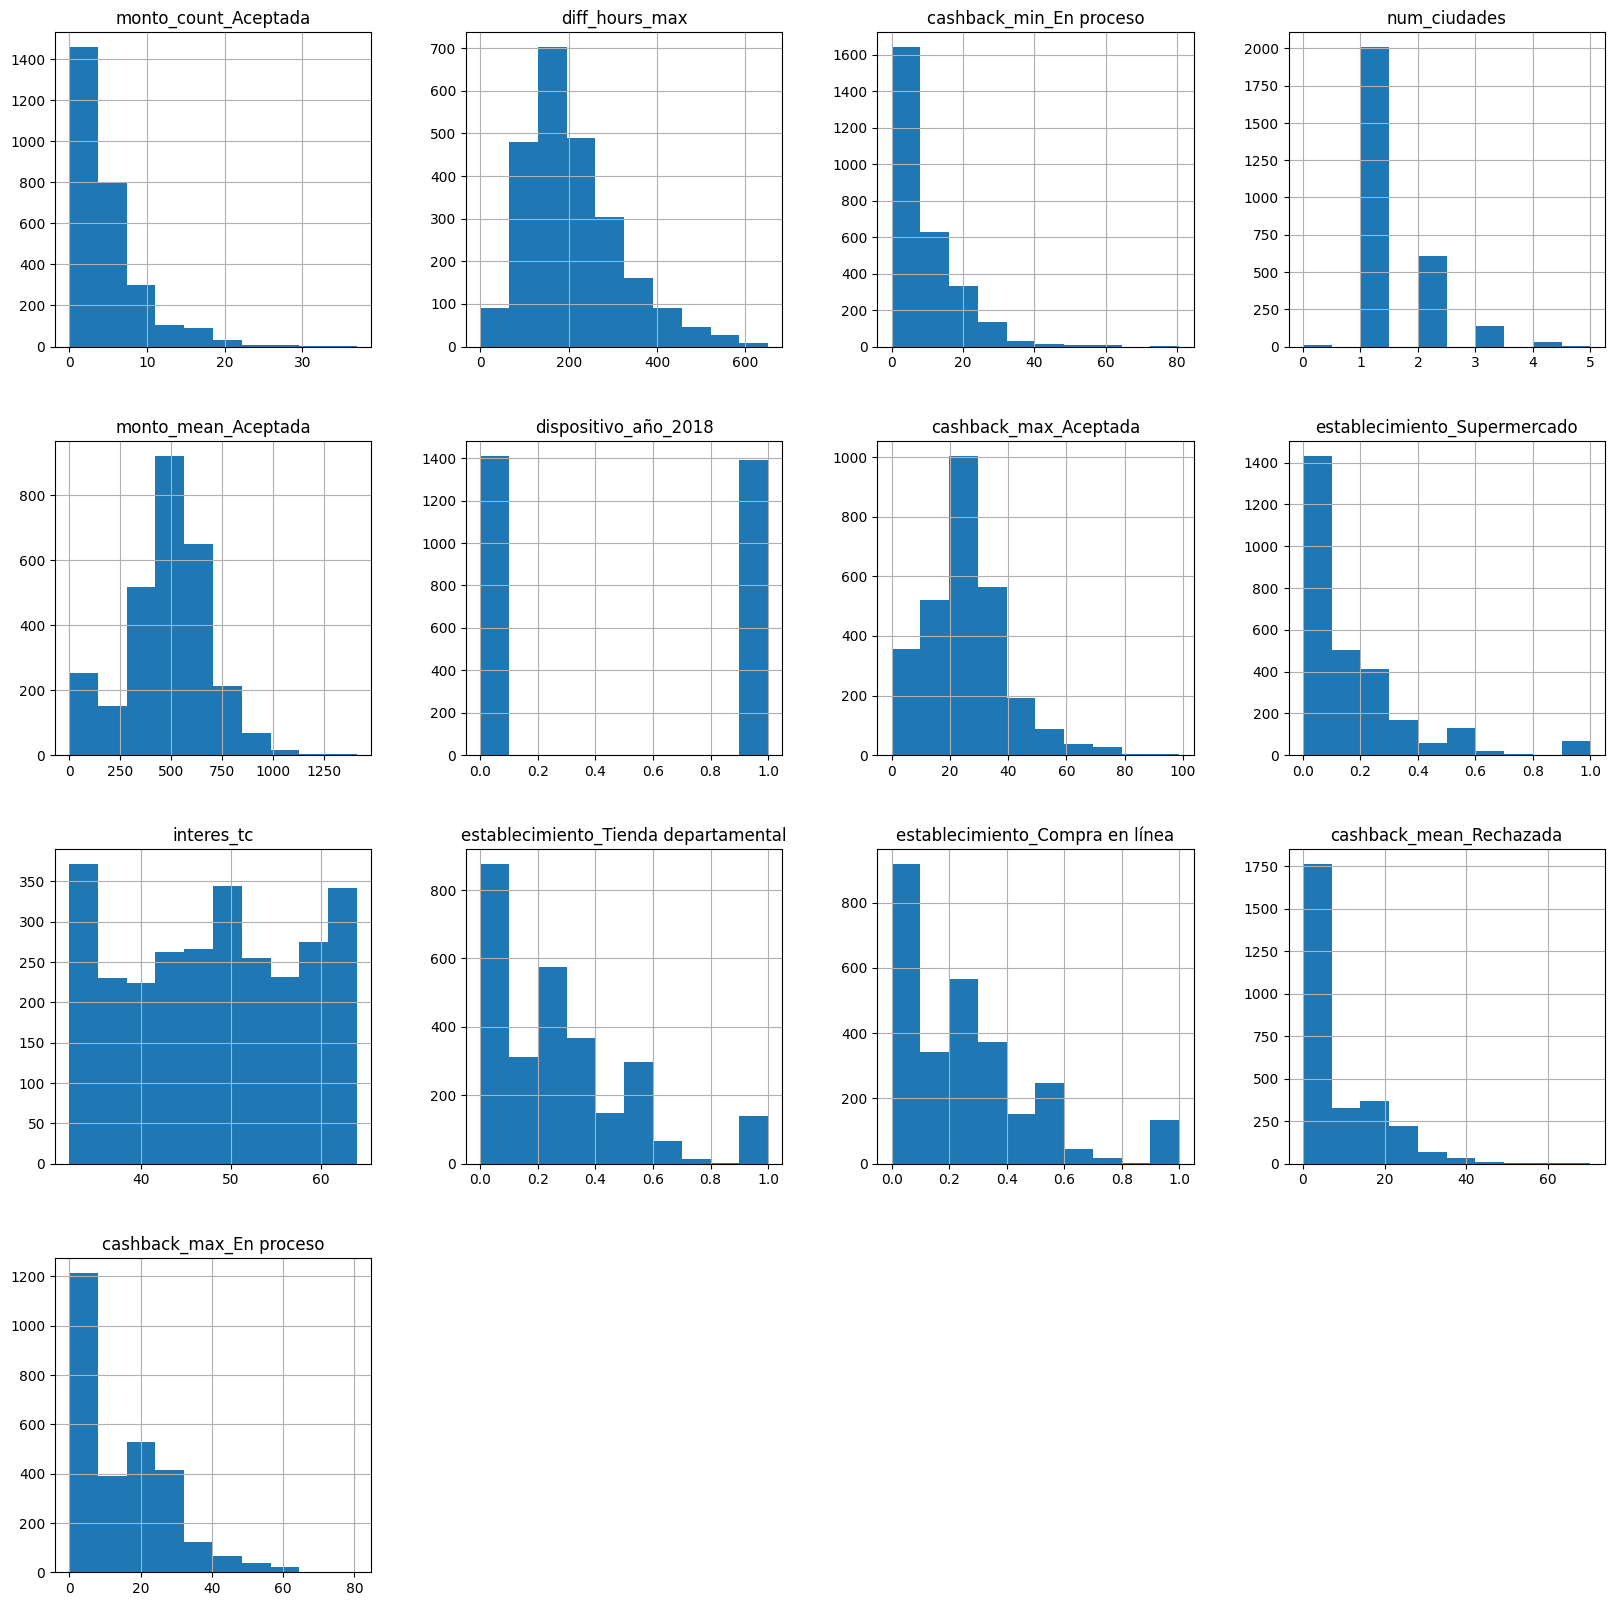

In [129]:
X_train[features].hist(figsize=(20,20));

## Modelado


### Regresión logística

In [181]:
modelo_logit = supervisado_clasificacion(
    X_entrenamiento=X_train[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_entrenamiento=y_train,
    X_prueba=X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_prueba=y_test,
    semilla=230522,
    folds=3,
    iteraciones=1,
    score="roc_auc",
    param_grid = {
        "penalty": ['l1', 'l2', 'elasticnet', 'none'] ,
        "tol": [x/2500 for x in range(26)],
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "random_state": [230522]}
)



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The total space of parameters 520 is smaller than n_iter=521. Running 520 iterations. For exhaustive searches, use GridSearchCV.


Fitting 3 folds for each of 520 candidates, totalling 1560 fits
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0048;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0048;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0064;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0068;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0088;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0092;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0092;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=newton-cg, tol=0.0092;, score=-1000

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/

[CV 2/3] END penalty=none, random_state=230522, solver=sag, tol=0.0016;, score=0.601 total time=   0.1s
[CV 3/3] END penalty=none, random_state=230522, solver=sag, tol=0.0016;, score=0.574 total time=   0.1s
[CV 1/3] END penalty=none, random_state=230522, solver=sag, tol=0.002;, score=0.619 total time=   0.1s
[CV 2/3] END penalty=none, random_state=230522, solver=sag, tol=0.002;, score=0.601 total time=   0.1s
[CV 3/3] END penalty=none, random_state=230522, solver=sag, tol=0.002;, score=0.574 total time=   0.1s
[CV 1/3] END penalty=none, random_state=230522, solver=sag, tol=0.0024;, score=0.619 total time=   0.1s
[CV 2/3] END penalty=none, random_state=230522, solver=sag, tol=0.0024;, score=0.601 total time=   0.1s
[CV 3/3] END penalty=none, random_state=230522, solver=sag, tol=0.0024;, score=0.574 total time=   0.1s
[CV 1/3] END penalty=none, random_state=230522, solver=sag, tol=0.0028;, score=0.619 total time=   0.1s
[CV 2/3] END penalty=none, random_state=230522, solver=sag, tol=0.0

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/v

[CV 3/3] END penalty=none, random_state=230522, solver=saga, tol=0.0016;, score=0.543 total time=   0.1s
[CV 1/3] END penalty=none, random_state=230522, solver=saga, tol=0.002;, score=0.583 total time=   0.2s
[CV 2/3] END penalty=none, random_state=230522, solver=saga, tol=0.002;, score=0.573 total time=   0.1s
[CV 3/3] END penalty=none, random_state=230522, solver=saga, tol=0.002;, score=0.543 total time=   0.2s
[CV 1/3] END penalty=none, random_state=230522, solver=saga, tol=0.0024;, score=0.583 total time=   0.1s
[CV 2/3] END penalty=none, random_state=230522, solver=saga, tol=0.0024;, score=0.573 total time=   0.1s
[CV 3/3] END penalty=none, random_state=230522, solver=saga, tol=0.0024;, score=0.543 total time=   0.1s
[CV 1/3] END penalty=none, random_state=230522, solver=saga, tol=0.0028;, score=0.583 total time=   0.1s
[CV 3/3] END penalty=l1, random_state=230522, solver=newton-cg, tol=0.0004;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solve

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/v

[CV 2/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0032;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0032;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0036;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0036;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0036;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=sag, tol=0.004;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solver=sag, tol=0.004;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=l1, random_state=230522, solver=sag, tol=0.004;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0044;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, sol

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/urielm

[CV 1/3] END penalty=l1, random_state=230522, solver=newton-cg, tol=0.0072;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solver=newton-cg, tol=0.0072;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0008;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0008;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0008;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0012;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0056;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0056;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=l1, random_state=230522, solver=lbfgs, tol=0.0056;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

[CV 3/3] END penalty=elasticnet, random_state=230522, solver=lbfgs, tol=0.0068;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0052;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0052;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0056;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0056;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0056;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.006;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.006;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-pac

[CV 3/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0048;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0052;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0096;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0096;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.0096;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.01;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.01;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=elasticnet, random_state=230522, solver=liblinear, tol=0.01;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=elasticnet, random_state=

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be 

[CV 3/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0064;, score=0.727 total time=   0.1s
[CV 1/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0068;, score=0.768 total time=   0.1s
[CV 2/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0068;, score=0.743 total time=   0.0s
[CV 3/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0068;, score=0.727 total time=   0.1s
[CV 1/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0072;, score=0.768 total time=   0.1s
[CV 2/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0072;, score=0.743 total time=   0.1s
[CV 3/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0072;, score=0.726 total time=   0.0s
[CV 1/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0076;, score=0.768 total time=   0.1s
[CV 2/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0076;, score=0.742 total time=   0.1s
[CV 3/3] END penalty=l2, random_state=230522, solver=sag, tol=0.0076;, score=0.726

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

[CV 3/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0084;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0088;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0088;, score=-1000.000 total time=   0.0s
[CV 3/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0088;, score=-1000.000 total time=   0.0s
[CV 1/3] END penalty=l1, random_state=230522, solver=sag, tol=0.0092;, score=-1000.000 total time=   0.0s
[CV 2/3] END penalty=l2, random_state=230522, solver=newton-cg, tol=0.0012;, score=0.790 total time=   0.1s
[CV 3/3] END penalty=l2, random_state=230522, solver=newton-cg, tol=0.0012;, score=0.772 total time=   0.1s
[CV 1/3] END penalty=l2, random_state=230522, solver=newton-cg, tol=0.0016;, score=0.841 total time=   0.1s
[CV 2/3] END penalty=l2, random_state=230522, solver=newton-cg, tol=0.0016;, score=0.790 total time=   0.1s
[CV 3/3] END penalty=l2, random_state=


708 fits failed out of a total of 1560.
The score on these train-test partitions for these parameters will be set to -1000.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueE

In [182]:
scores_logit = supervisado_clasificacion_scores(
    X_entrenamiento=X_train[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_entrenamiento=y_train,
    X_prueba=X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_prueba=y_test,
    semilla=230522,
    folds=10,
    score="roc_auc",
    parameters = modelo_logit["regresion_logistica"]["modelo"].best_params_
)

In [183]:
scores_logit

modelo       roc  score_mean_cross_val  score_std_cross_val   
0  regresion_logistica  0.770358              0.799613              0.04859  \

   accuracy        F1                confusion        ks       thr  
0  0.696667  0.436533  [[695, 307], [57, 141]]  0.412478  0.151672

### Árbol de decisión y Random forest

In [144]:
modelo_decision_tree = supervisado_clasificacion_DecisionTree(
    X_entrenamiento=X_train[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_entrenamiento=y_train,
    X_prueba=X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_prueba=y_test,
    semilla=230522,
    folds_search=3,
    folds_CV=10,
    iteraciones=0.2,
    score="roc_auc",
    param_grid_tree = {
        "criterion" : ["gini", "entropy"],
        "max_depth" : [x for x in range(3,21)],
        "min_samples_split": [x/100 for x in range(1,11)],
        "min_samples_leaf": [x/100 for x in range(1,11)],
        "max_features" : [None,"auto", "sqrt", "log2"],
        "random_state": [230522]
    },
    param_grid_forest = {
        "criterion" : ["gini", "entropy"],
        "max_depth" : [x for x in range(3,21)],
        "min_samples_split": [x*10 for x in range(1,11)],
        "min_samples_leaf": [x*10 for x in range(1,11)],
        "max_features" : [None,"auto", "sqrt", "log2"],
        "random_state": [230522]
    }
)
#10:22

Fitting 3 folds for each of 2881 candidates, totalling 8643 fits
[CV 2/3] END criterion=gini, max_depth=18, max_features=sqrt, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.720 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.06, random_state=230522;, score=0.780 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.06, random_state=230522;, score=0.737 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=0.08, min_samples_split=0.04, random_state=230522;, score=0.755 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.757 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.02, random_state

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.758 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.717 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=19, max_features=log2, min_samples_leaf=0.09, min_samples_split=0.09, random_state=230522;, score=0.756 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=19, max_features=log2, min_samples_leaf=0.09, min_samples_split=0.09, random_state=230522;, score=0.762 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=19, max_features=log2, min_samples_leaf=0.09, min_samples_split=0.09, random_state=230522;, score=0.729 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=0.04, min_samples_split=0.03, random_state=230522;, score=0.776 total time=   0.0s
[CV 2/3] END criterion=gini,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.724 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=None, min_samples_leaf=0.1, min_samples_split=0.1, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.722 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=0.02, min_samples_split=0.08, random_state=230522;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=0.02, min_samples_split=0.08, random_state=230522;, score=0.722 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=0.02, min_samples_split=0.08, random_state=230522;, score=0.704 total time=   0.0s
[CV 1/3] END criterion=gini, max_dept

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.770 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.765 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.721 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=7, max_features=None, min_samples_leaf=0.1, min_samples_split=0.09, random_state=230522;, score=0.780 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=7, max_features=None, min_samples_leaf=0.1, min_samples_split=0.09, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=7, max_features=None, min_samples_leaf=0.1, min_samples_split=0.09, random_state=230522;, score=0.741 total time=   0.0s
[CV 1/3] END criterion

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.07, random_state=230522;, score=0.744 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.07, random_state=230522;, score=0.736 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.774 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.749 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.715 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.02, random_state=230522;, score=0.751 total time=   0.0s
[CV 2/3] END cri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.02, random_state=230522;, score=0.757 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.02, random_state=230522;, score=0.725 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.02, random_state=230522;, score=0.725 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=14, max_features=log2, min_samples_leaf=0.04, min_samples_split=0.08, random_state=230522;, score=0.790 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=14, max_features=log2, min_samples_leaf=0.04, min_samples_split=0.08, random_state=230522;, score=0.721 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=14, max_features=log2, min_samples_leaf=0.04, min_samples_split=0.08, random_state=230522;, score=0.712 total time=   0.0s
[CV 1/3] END criterion=entro

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.714 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.734 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=17, max_features=auto, min_samples_leaf=0.01, min_samples_split=0.1, random_state=230522;, score=0.778 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=17, max_features=auto, min_samples_leaf=0.01, min_samples_split=0.1, random_state=230522;, score=0.723 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=17, max_features=auto, min_samples_leaf=0.01, min_samples_split=0.1, random_state=230522;, score=0.733 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=9, max_features=None, min_samples_leaf=0.05, min_samples_split=0.09, random_state=230522;, score=0.782 total time=   0.0s
[CV 2/3] END cri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=0.05, min_samples_split=0.06, random_state=230522;, score=0.728 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.04, random_state=230522;, score=0.774 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.04, random_state=230522;, score=0.749 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.04, random_state=230522;, score=0.715 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.09, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.09, random_state=230522;, score=0.727 total time=   0.0s
[CV 3/3] END criterio

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=0.08, min_samples_split=0.09, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=0.08, min_samples_split=0.09, random_state=230522;, score=0.742 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=0.09, min_samples_split=0.06, random_state=230522;, score=0.756 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=0.09, min_samples_split=0.06, random_state=230522;, score=0.762 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=0.09, min_samples_split=0.06, random_state=230522;, score=0.729 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=0.04, min_samples_split=0.05, random_state=230522;, score=0.772 total time=   0.0s
[CV 2/3] END criteri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.716 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=0.03, min_samples_split=0.02, random_state=230522;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=0.03, min_samples_split=0.02, random_state=230522;, score=0.721 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=0.03, min_samples_split=0.02, random_state=230522;, score=0.715 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.02, random_state=230522;, score=0.784 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.02, random_state=230522;, score=0.720 total time=   0.0s
[CV 3/3] END criteri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.06, random_state=230522;, score=0.715 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.06, min_samples_split=0.03, random_state=230522;, score=0.774 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.06, min_samples_split=0.03, random_state=230522;, score=0.753 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.06, min_samples_split=0.03, random_state=230522;, score=0.730 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=0.08, min_samples_split=0.04, random_state=230522;, score=0.783 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=0.08, min_samples_split=0.04, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criter

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=12, max_features=log2, min_samples_leaf=0.04, min_samples_split=0.09, random_state=230522;, score=0.748 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=12, max_features=log2, min_samples_leaf=0.04, min_samples_split=0.09, random_state=230522;, score=0.730 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.01, min_samples_split=0.02, random_state=230522;, score=0.740 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.01, min_samples_split=0.02, random_state=230522;, score=0.723 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.01, min_samples_split=0.02, random_state=230522;, score=0.693 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.09, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=gini, max_depth=4, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.744 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.05, random_state=230522;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.05, random_state=230522;, score=0.721 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.05, random_state=230522;, score=0.721 total time=   0.0s
[CV 1/3] END criterion=gini, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.780 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.741 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.1, min_samples_split=0.01, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.1, min_samples_split=0.01, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=0.1, min_samples_split=0.01, random_state=230522;, score=0.743 total time=   0.0s
[CV 1/3] END criterion=gini,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=0.09, min_samples_split=0.01, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=0.09, min_samples_split=0.01, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=0.09, min_samples_split=0.01, random_state=230522;, score=0.749 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.784 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.742 total time=   0.0s
[CV 1/3] END criter

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=gini, max_depth=13, max_features=None, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.763 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.1, min_samples_split=0.05, random_state=230522;, score=0.757 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.1, min_samples_split=0.05, random_state=230522;, score=0.739 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.1, min_samples_split=0.05, random_state=230522;, score=0.730 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=0.06, min_samples_split=0.05, random_state=230522;, score=0.784 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=0.06, min_samples_split=0.05, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=entropy

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.04, random_state=230522;, score=0.725 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=0.05, min_samples_split=0.03, random_state=230522;, score=0.720 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=0.05, min_samples_split=0.03, random_state=230522;, score=0.728 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=11, max_features=auto, min_samples_leaf=0.02, min_samples_split=0.09, random_state=230522;, score=0.793 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=11, max_features=auto, min_samples_leaf=0.02, min_samples_split=0.09, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=11, max_features=auto, min_samples_leaf=0.02, min_samples_split=0.09, random_state=230522;, score=0.700 total time=   0.0s
[CV 1/3] END criterion=entrop

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.790 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.721 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.712 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.03, random_state=230522;, score=0.772 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.03, random_state=230522;, score=0.765 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.03, random_state=230522;, score=0.721 total time=   0.0s
[CV 1/3] END criterion

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_leaf=0.09, min_samples_split=0.03, random_state=230522;, score=0.771 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_leaf=0.09, min_samples_split=0.03, random_state=230522;, score=0.742 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=13, max_features=log2, min_samples_leaf=0.09, min_samples_split=0.05, random_state=230522;, score=0.779 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=13, max_features=log2, min_samples_leaf=0.09, min_samples_split=0.05, random_state=230522;, score=0.771 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=13, max_features=log2, min_samples_leaf=0.09, min_samples_split=0.05, random_state=230522;, score=0.742 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.784 total time=   0.0s
[CV 2/3] EN

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=0.07, min_samples_split=0.01, random_state=230522;, score=0.784 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=0.07, min_samples_split=0.01, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=0.07, min_samples_split=0.01, random_state=230522;, score=0.742 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=0.02, min_samples_split=0.06, random_state=230522;, score=0.766 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=0.02, min_samples_split=0.06, random_state=230522;, score=0.749 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=0.02, min_samples_split=0.06, random_state=230522;, score=0.722 total time=   0.0s
[CV 1/3] END 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=0.07, min_samples_split=0.09, random_state=230522;, score=0.742 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.769 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.731 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.05, random_state=230522;, score=0.784 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.05, random_state=230522;, score=0.720 total time=   0.0s
[CV 3/3] END crite

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=0.08, min_samples_split=0.08, random_state=230522;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=0.08, min_samples_split=0.08, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=0.08, min_samples_split=0.08, random_state=230522;, score=0.744 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.746 total time=   0.0s
[CV 1/3] END criterion=entropy,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=0.06, min_samples_split=0.07, random_state=230522;, score=0.731 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=0.08, min_samples_split=0.07, random_state=230522;, score=0.757 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=0.08, min_samples_split=0.07, random_state=230522;, score=0.763 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=0.08, min_samples_split=0.07, random_state=230522;, score=0.729 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=17, max_features=None, min_samples_leaf=0.02, min_samples_split=0.02, random_state=230522;, score=0.777 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=0.09, min_samples_split=0.05, random_state=230522;, score=0.779 total time=   0.0s
[CV 2/3] END criterion

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=0.06, min_samples_split=0.03, random_state=230522;, score=0.774 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=0.06, min_samples_split=0.03, random_state=230522;, score=0.753 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=0.06, min_samples_split=0.03, random_state=230522;, score=0.730 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=0.09, min_samples_split=0.04, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=0.09, min_samples_split=0.04, random_state=230522;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=0.09, min_samples_split=0.04, random_state=230522;, score=0.749 total time=   0.0s
[CV 1/3] END criterion=entro

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=0.1, min_samples_split=0.02, random_state=230522;, score=0.730 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=13, max_features=None, min_samples_leaf=0.04, min_samples_split=0.06, random_state=230522;, score=0.783 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=13, max_features=None, min_samples_leaf=0.04, min_samples_split=0.06, random_state=230522;, score=0.754 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.761 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.724 total time=   0.0s
[CV 1/3] END criterion=gin

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.749 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=0.04, min_samples_split=0.01, random_state=230522;, score=0.715 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.07, random_state=230522;, score=0.770 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.07, random_state=230522;, score=0.738 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.07, random_state=230522;, score=0.714 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=6, max_features=None, min_samples_leaf=0.1, min_samples_split=0.1, random_state=230522;, score=0.780 total time=   0.0s
[CV 3/3] END criterion

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=0.08, min_samples_split=0.06, random_state=230522;, score=0.768 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=0.02, min_samples_split=0.04, random_state=230522;, score=0.757 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=0.02, min_samples_split=0.04, random_state=230522;, score=0.751 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=0.02, min_samples_split=0.04, random_state=230522;, score=0.696 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=None, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.785 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=None, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.760 total time=   0.0s
[CV 3/3] END criteri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 2/3] END criterion=gini, max_depth=9, max_features=None, min_samples_leaf=0.08, min_samples_split=0.02, random_state=230522;, score=0.755 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.766 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.769 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=0.06, min_samples_split=0.09, random_state=230522;, score=0.731 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=0.05, min_samples_split=0.01, random_state=230522;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=0.05, min_samples_split=0.01, random_state=230522;, score=0.761 total time=   0.0s
[CV 3/3] END criteri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.780 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.737 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=0.05, min_samples_split=0.08, random_state=230522;, score=0.731 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.03, min_samples_split=0.09, random_state=230522;, score=0.731 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=log2, min_samples_leaf=0.02, min_samples_split=0.01, random_state=230522;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=18, max_features=log2, min_samples_leaf=0.02, min_samples_split=0.01, random_state=230522;, score=0.747 total time=   0.0s
[CV 3/3] END crit

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=6, max_features=None, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.775 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=0.01, min_samples_split=0.05, random_state=230522;, score=0.738 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=0.01, min_samples_split=0.05, random_state=230522;, score=0.692 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=0.06, min_samples_split=0.01, random_state=230522;, score=0.766 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=0.06, min_samples_split=0.01, random_state=230522;, score=0.742 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=0.06, min_samples_split=0.01, random_state=230522;, score=0.738 total time=   0.0s
[CV 1/3] END criterion=gi

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=9, max_features=None, min_samples_leaf=0.04, min_samples_split=0.06, random_state=230522;, score=0.783 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=9, max_features=None, min_samples_leaf=0.04, min_samples_split=0.06, random_state=230522;, score=0.754 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=9, max_features=None, min_samples_leaf=0.04, min_samples_split=0.06, random_state=230522;, score=0.733 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.04, random_state=230522;, score=0.753 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.04, random_state=230522;, score=0.762 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.04, random_state=230522;, score=0.717 total time=   0.0s
[CV 1/3] END criterion=en

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=0.08, min_samples_split=0.1, random_state=230522;, score=0.782 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=0.08, min_samples_split=0.1, random_state=230522;, score=0.758 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=0.08, min_samples_split=0.1, random_state=230522;, score=0.735 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=17, max_features=None, min_samples_leaf=0.02, min_samples_split=0.03, random_state=230522;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=17, max_features=None, min_samples_leaf=0.02, min_samples_split=0.03, random_state=230522;, score=0.740 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=17, max_features=None, min_samples_leaf=0.02, min_samples_split=0.03, random_state=230522;, score=0.738 total time=   0.0s
[CV 1/3] END cri

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 3/3] END criterion=gini, max_depth=19, max_features=sqrt, min_samples_leaf=0.05, min_samples_split=0.01, random_state=230522;, score=0.728 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=0.02, min_samples_split=0.03, random_state=230522;, score=0.760 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=0.02, min_samples_split=0.03, random_state=230522;, score=0.744 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=0.02, min_samples_split=0.03, random_state=230522;, score=0.719 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.09, random_state=230522;, score=0.772 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.09, random_state=230522;, score=0.765 total time=   0.0s
[CV 3/3] END criterion=entr

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been depre

[CV 1/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.08, random_state=230522;, score=0.753 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.08, random_state=230522;, score=0.729 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=0.03, min_samples_split=0.08, random_state=230522;, score=0.719 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.724 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.760 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=0.03, min_samples_split=0.06, random_state=230522;, score=0.696 total time=   0.0s
[CV 1/3] END criterion

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=9, max_features=None, min_samples_leaf=60, min_samples_split=60, random_state=230522;, score=0.790 total time=   0.7s
[CV 3/3] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=100, random_state=230522;, score=0.773 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=20, min_samples_split=100, random_state=230522;, score=0.792 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=70, min_samples_split=100, random_state=230522;, score=0.776 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=70, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=70, min_samples_split=10, random_state=230522;, score=0.788 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=1

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, random_state=230522;, score=0.772 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_leaf=70, min_samples_split=30, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=13, max_features=None, min_samples_leaf=90, min_samples_split=90, random_state=230522;, score=0.788 total time=   0.7s
[CV 2/3] END criterion=entropy, max_depth=19, max_features=log2, min_samples_leaf=70, min_samples_split=30, random_state=230522;, score=0.787 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=40, min_samples_split=50, random_state=230522;, score=0.827 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.770 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=2

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=40, min_samples_split=30, random_state=230522;, score=0.790 total time=   0.8s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=70, min_samples_split=30, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=90, min_samples_split=80, random_state=230522;, score=0.786 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=19, max_features=auto, min_samples_leaf=80, min_samples_split=90, random_state=230522;, score=0.822 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=60, random_state=230522;, score=0.767 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=10, random_state=230522;, score=0.791 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=16, max_f

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=90, min_samples_split=80, random_state=230522;, score=0.786 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=70, random_state=230522;, score=0.831 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=16, max_features=None, min_samples_leaf=90, min_samples_split=50, random_state=230522;, score=0.772 total time=   0.6s
[CV 2/3] END criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=50, min_samples_split=40, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=20, min_samples_split=60, random_state=230522;, score=0.833 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=9, max_features=auto, min_samples_leaf=70, min_samples_split=90, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=70, random_state=230522;, score=0.772 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.790 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=20, min_samples_split=10, random_state=230522;, score=0.830 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.774 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=100, min_samples_split=20, random_state=230522;, score=0.788 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=100, random_state=230522;, score=0.824 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=5, 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=8, max_features=None, min_samples_leaf=50, min_samples_split=90, random_state=230522;, score=0.766 total time=   0.9s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=50, min_samples_split=40, random_state=230522;, score=0.772 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=40, min_samples_split=90, random_state=230522;, score=0.768 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=40, min_samples_split=60, random_state=230522;, score=0.772 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=11, max_features=log2, min_samples_leaf=20, min_samples_split=20, random_state=230522;, score=0.771 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=14, max_features=auto, min_samples_leaf=80, min_samples_split=10, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=17,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=40, random_state=230522;, score=0.827 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.774 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.768 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=90, random_state=230522;, score=0.792 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.819 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=9, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, random_state=230522;, score=0.793 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=40, min_samples_split=70, random_state=230522;, score=0.769 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=12, max_features=auto, min_samples_leaf=60, min_samples_split=70, random_state=230522;, score=0.770 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=7, max_features=None, min_samples_leaf=10, min_samples_split=70, random_state=230522;, score=0.768 total time=   1.0s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=None, min_samples_leaf=90, min_samples_split=90, random_state=230522;, score=0.788 total time=   0.7s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.790 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=12, max_

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=7, max_features=None, min_samples_leaf=70, min_samples_split=100, random_state=230522;, score=0.788 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, random_state=230522;, score=0.820 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.768 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, random_state=230522;, score=0.785 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=30, random_state=230522;, score=0.827 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=None, min_samples_leaf=70, min_samples_split=40, random_state=230522;, score=0.768 total time=   0.8s
[CV 1/3] END criterion=gini, max_depth=12,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=20, min_samples_split=90, random_state=230522;, score=0.792 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=20, random_state=230522;, score=0.832 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=80, min_samples_split=60, random_state=230522;, score=0.766 total time=   0.6s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=80, min_samples_split=80, random_state=230522;, score=0.787 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=10, min_samples_split=90, random_state=230522;, score=0.834 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=80, min_samples_split=20, random_state=230522;, score=0.774 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=9, max_f

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=20, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=20, min_samples_split=50, random_state=230522;, score=0.789 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=40, min_samples_split=50, random_state=230522;, score=0.826 total time=   0.9s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=30, min_samples_split=70, random_state=230522;, score=0.790 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=80, min_samples_split=70, random_state=230522;, score=0.789 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=40, min_samples_split=90, random_state=230522;, score=0.792 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=10, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=19, max_features=log2, min_samples_leaf=40, min_samples_split=60, random_state=230522;, score=0.772 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=90, min_samples_split=50, random_state=230522;, score=0.786 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_leaf=90, min_samples_split=30, random_state=230522;, score=0.819 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=90, min_samples_split=20, random_state=230522;, score=0.819 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.819 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=230522;, score=0.771 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=19, max_fe

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=20, max_features=None, min_samples_leaf=100, min_samples_split=10, random_state=230522;, score=0.812 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=90, min_samples_split=60, random_state=230522;, score=0.775 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=100, min_samples_split=90, random_state=230522;, score=0.788 total time=   0.6s
[CV 3/3] END criterion=entropy, max_depth=13, max_features=auto, min_samples_leaf=10, min_samples_split=30, random_state=230522;, score=0.770 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=log2, min_samples_leaf=60, min_samples_split=80, random_state=230522;, score=0.787 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=50, min_samples_split=70, random_state=230522;, score=0.827 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=100, min_samples_split=60, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=7, max_features=None, min_samples_leaf=50, min_samples_split=20, random_state=230522;, score=0.825 total time=   1.0s
[CV 1/3] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=20, min_samples_split=60, random_state=230522;, score=0.828 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=18, max_features=log2, min_samples_leaf=80, min_samples_split=70, random_state=230522;, score=0.787 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=100, min_samples_split=10, random_state=230522;, score=0.820 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=13, max_features=log2, min_samples_leaf=60, min_samples_split=40, random_state=230522;, score=0.787 total time=   0.4s
[CV 3/3] END criterion=entropy, max

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=90, min_samples_split=40, random_state=230522;, score=0.770 total time=   0.7s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=log2, min_samples_leaf=20, min_samples_split=70, random_state=230522;, score=0.790 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=10, min_samples_split=60, random_state=230522;, score=0.836 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.834 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=9, max_features=auto, min_samples_leaf=20, min_samples_split=50, random_state=230522;, score=0.835 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, random_state=230522;, score=0.772 total time=   0.5s
[CV 2/3] END criterion=entropy, max_d

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, random_state=230522;, score=0.829 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, random_state=230522;, score=0.774 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=9, max_features=log2, min_samples_leaf=60, min_samples_split=30, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, max_features=None, min_samples_leaf=30, min_samples_split=60, random_state=230522;, score=0.825 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=230522;, score=0.826 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.788 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=15, max_feat

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=20, max_features=None, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.832 total time=   1.2s
[CV 1/3] END criterion=entropy, max_depth=12, max_features=auto, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.831 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=90, min_samples_split=100, random_state=230522;, score=0.786 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=19, max_features=None, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.832 total time=   1.1s
[CV 2/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=70, min_samples_split=50, random_state=230522;, score=0.788 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=30, min_samples_split=90, random_state=230522;, score=0.792 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.790 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=16, max_features=auto, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.830 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=18, max_features=log2, min_samples_leaf=80, min_samples_split=10, random_state=230522;, score=0.822 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=30, min_samples_split=70, random_state=230522;, score=0.830 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=60, min_samples_split=30, random_state=230522;, score=0.788 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.792 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=8, max_

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=90, random_state=230522;, score=0.821 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.772 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=16, max_features=auto, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.771 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=50, min_samples_split=60, random_state=230522;, score=0.823 total time=   0.8s
[CV 1/3] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=60, min_samples_split=30, random_state=230522;, score=0.828 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.828 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=4, max_fe

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=90, min_samples_split=100, random_state=230522;, score=0.813 total time=   0.7s
[CV 3/3] END criterion=entropy, max_depth=18, max_features=log2, min_samples_leaf=40, min_samples_split=40, random_state=230522;, score=0.772 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=60, random_state=230522;, score=0.827 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=13, max_features=sqrt, min_samples_leaf=50, min_samples_split=30, random_state=230522;, score=0.827 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=60, random_state=230522;, score=0.764 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=17, max_features=log2, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.771 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=8, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_leaf=80, min_samples_split=80, random_state=230522;, score=0.822 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=13, max_features=None, min_samples_leaf=100, min_samples_split=90, random_state=230522;, score=0.770 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=90, min_samples_split=10, random_state=230522;, score=0.819 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=90, min_samples_split=20, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.790 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, max_features=None, min_samples_leaf=30, min_samples_split=60, random_state=230522;, score=0.828 total time=   0.9s
[CV 2/3] END criterion=entropy, max_depth=18, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=100, random_state=230522;, score=0.790 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=9, max_features=None, min_samples_leaf=70, min_samples_split=10, random_state=230522;, score=0.819 total time=   0.8s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=80, min_samples_split=50, random_state=230522;, score=0.820 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=90, min_samples_split=30, random_state=230522;, score=0.776 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=11, max_features=None, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.829 total time=   0.9s
[CV 1/3] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, random_state=230522;, score=0.829 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, max_fea

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=80, min_samples_split=70, random_state=230522;, score=0.773 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=8, max_features=None, min_samples_leaf=90, min_samples_split=30, random_state=230522;, score=0.788 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=70, min_samples_split=80, random_state=230522;, score=0.765 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, random_state=230522;, score=0.831 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=70, min_samples_split=90, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=30, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=8, max_fea

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=80, min_samples_split=30, random_state=230522;, score=0.774 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=80, min_samples_split=70, random_state=230522;, score=0.819 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=60, random_state=230522;, score=0.792 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=18, max_features=log2, min_samples_leaf=80, min_samples_split=90, random_state=230522;, score=0.787 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=12, max_features=None, min_samples_leaf=80, min_samples_split=100, random_state=230522;, score=0.771 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=13, max_features=None, min_samples_leaf=90, min_samples_split=100, random_state=230522;, score=0.813 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=19, m

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=90, min_samples_split=60, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.794 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=10, random_state=230522;, score=0.832 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=90, min_samples_split=60, random_state=230522;, score=0.785 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=18, max_features=None, min_samples_leaf=10, min_samples_split=50, random_state=230522;, score=0.794 total time=   1.2s
[CV 3/3] END criterion=gini, max_depth=11, max_features=sqrt, min_samples_leaf=50, min_samples_split=30, random_state=230522;, score=0.771 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=10, max_fe

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=60, min_samples_split=30, random_state=230522;, score=0.771 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=50, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=11, max_features=log2, min_samples_leaf=60, min_samples_split=70, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=30, min_samples_split=10, random_state=230522;, score=0.828 total time=   0.9s
[CV 2/3] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=70, min_samples_split=20, random_state=230522;, score=0.788 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=11, max_features=auto, min_samples_leaf=20, min_samples_split=10, random_state=230522;, score=0.771 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=6, max_featu

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.774 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, max_features=None, min_samples_leaf=90, min_samples_split=100, random_state=230522;, score=0.788 total time=   0.6s
[CV 1/3] END criterion=entropy, max_depth=17, max_features=None, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.821 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=16, max_features=auto, min_samples_leaf=20, min_samples_split=20, random_state=230522;, score=0.791 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=20, max_features=None, min_samples_leaf=10, min_samples_split=20, random_state=230522;, score=0.827 total time=   1.1s
[CV 3/3] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=80, min_samples_split=30, random_state=230522;, score=0.771 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=20, max_fea

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=13, max_features=sqrt, min_samples_leaf=60, min_samples_split=80, random_state=230522;, score=0.828 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=20, max_features=None, min_samples_leaf=50, min_samples_split=100, random_state=230522;, score=0.825 total time=   0.9s
[CV 2/3] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=90, min_samples_split=50, random_state=230522;, score=0.786 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=60, min_samples_split=30, random_state=230522;, score=0.828 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=30, min_samples_split=30, random_state=230522;, score=0.794 total time=   0.6s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=None, min_samples_leaf=10, min_samples_split=60, random_state=230522;, score=0.833 total time=   1.3s
[CV 1/3] END criterion=entropy, max_dept

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=17, max_features=log2, min_samples_leaf=60, min_samples_split=70, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=log2, min_samples_leaf=40, min_samples_split=70, random_state=230522;, score=0.828 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=50, min_samples_split=100, random_state=230522;, score=0.772 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=20, max_features=None, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.788 total time=   0.6s
[CV 3/3] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=40, min_samples_split=80, random_state=230522;, score=0.772 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=90, min_samples_split=40, random_state=230522;, score=0.786 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=17, 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=12, max_features=auto, min_samples_leaf=90, min_samples_split=70, random_state=230522;, score=0.786 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=16, max_features=None, min_samples_leaf=50, min_samples_split=80, random_state=230522;, score=0.825 total time=   0.9s
[CV 1/3] END criterion=gini, max_depth=14, max_features=auto, min_samples_leaf=90, min_samples_split=90, random_state=230522;, score=0.819 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=7, max_features=None, min_samples_leaf=80, min_samples_split=40, random_state=230522;, score=0.772 total time=   0.8s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=log2, min_samples_leaf=20, min_samples_split=30, random_state=230522;, score=0.834 total time=   0.5s
[CV 3/3] END criterion=entropy, max_de

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=19, max_features=None, min_samples_leaf=90, min_samples_split=90, random_state=230522;, score=0.815 total time=   0.8s
[CV 3/3] END criterion=entropy, max_depth=12, max_features=log2, min_samples_leaf=90, min_samples_split=30, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=auto, min_samples_leaf=10, min_samples_split=30, random_state=230522;, score=0.789 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=90, min_samples_split=20, random_state=230522;, score=0.821 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=90, min_samples_split=20, random_state=230522;, score=0.776 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=12, max_features=log2, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.770 total time=   0.4s
[CV 1/3] END criterion=gini, max_d

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=11, max_features=None, min_samples_leaf=30, min_samples_split=80, random_state=230522;, score=0.828 total time=   0.9s
[CV 2/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=100, min_samples_split=10, random_state=230522;, score=0.788 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=80, min_samples_split=100, random_state=230522;, score=0.773 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=11, max_features=log2, min_samples_leaf=90, min_samples_split=100, random_state=230522;, score=0.786 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=8, max_features=None, min_samples_leaf=80, min_samples_split=90, random_state=230522;, score=0.772 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=14, max_features=None, min_samples_leaf=80, min_samples_split=100, random_state=230522;, score=0.788 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=11, 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=14, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, random_state=230522;, score=0.770 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=30, min_samples_split=20, random_state=230522;, score=0.787 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=12, max_features=None, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.832 total time=   1.1s
[CV 1/3] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=70, min_samples_split=60, random_state=230522;, score=0.825 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=13, max_features=auto, min_samples_leaf=40, min_samples_split=40, random_state=230522;, score=0.772 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=70, min_samples_split=30, random_state=230522;, score=0.789 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=70, min_samples_split=100, random_state=230522;, score=0.765 total time=   0.8s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=230522;, score=0.792 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.769 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=80, min_samples_split=90, random_state=230522;, score=0.771 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.828 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.768 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=13, max_fe

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=50, random_state=230522;, score=0.819 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=14, max_features=None, min_samples_leaf=80, min_samples_split=50, random_state=230522;, score=0.772 total time=   0.8s
[CV 1/3] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=60, min_samples_split=20, random_state=230522;, score=0.823 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.770 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=80, min_samples_split=80, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=9, max_features=None, min_samples_leaf=80, min_samples_split=100, random_state=230522;, score=0.817 total time=   0.8s
[CV 3/3] END criterion=entropy, max_depth=20,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=9, max_features=None, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.788 total time=   0.6s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=60, min_samples_split=10, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, random_state=230522;, score=0.819 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=60, random_state=230522;, score=0.833 total time=   0.6s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=None, min_samples_leaf=60, min_samples_split=40, random_state=230522;, score=0.821 total time=   0.9s
[CV 3/3] END criterion=entropy, max_depth=14, max_features=None, min_samples_leaf=80, min_samples_split=10, random_state=230522;, score=0.772 total time=   0.8s
[CV 1/3] END criterion=gini, max_depth=

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=20, max_features=None, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.788 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=17, max_features=log2, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.774 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=80, min_samples_split=80, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=20, min_samples_split=20, random_state=230522;, score=0.830 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=18, max_features=auto, min_samples_leaf=60, min_samples_split=60, random_state=230522;, score=0.771 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=30, min_samples_split=20, random_state=230522;, score=0.769 total time=   1.0s
[CV 1/3] END criterion=gini, max_depth=19, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.775 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=30, min_samples_split=80, random_state=230522;, score=0.764 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=19, max_features=sqrt, min_samples_leaf=10, min_samples_split=90, random_state=230522;, score=0.834 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=80, min_samples_split=50, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=11, max_features=auto, min_samples_leaf=80, min_samples_split=10, random_state=230522;, score=0.789 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=13, max_features=auto, min_samples_leaf=20, min_samples_split=50, random_state=230522;, score=0.789 total time=   0.5s
[CV 2/3] END criterion=entropy, max_d

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=19, max_features=auto, min_samples_leaf=60, min_samples_split=40, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=40, min_samples_split=40, random_state=230522;, score=0.790 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=70, min_samples_split=90, random_state=230522;, score=0.819 total time=   0.9s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=80, min_samples_split=80, random_state=230522;, score=0.821 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=50, min_samples_split=50, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=60, min_samples_split=70, random_state=230522;, score=0.828 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=10, 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=12, max_features=None, min_samples_leaf=70, min_samples_split=50, random_state=230522;, score=0.788 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.792 total time=   0.6s
[CV 3/3] END criterion=entropy, max_depth=12, max_features=auto, min_samples_leaf=30, min_samples_split=80, random_state=230522;, score=0.770 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=18, max_features=None, min_samples_leaf=70, min_samples_split=70, random_state=230522;, score=0.768 total time=   0.9s
[CV 1/3] END criterion=gini, max_depth=9, max_features=None, min_samples_leaf=10, min_samples_split=30, random_state=230522;, score=0.828 total time=   1.1s
[CV 3/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=60, min_samples_split=70, random_state=230522;, score=0.771 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=17, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=90, min_samples_split=70, random_state=230522;, score=0.775 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=16, max_features=None, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.832 total time=   1.0s
[CV 2/3] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=70, min_samples_split=40, random_state=230522;, score=0.787 total time=   0.3s
[CV 1/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=30, min_samples_split=80, random_state=230522;, score=0.831 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=14, max_features=log2, min_samples_leaf=100, min_samples_split=100, random_state=230522;, score=0.819 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=90, min_samples_split=40, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, m

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=80, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.820 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=11, max_features=None, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.788 total time=   0.7s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=30, random_state=230522;, score=0.774 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, max_features=None, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.828 total time=   1.0s
[CV 2/3] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_leaf=30, min_samples_split=60, random_state=230522;, score=0.787 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=19, max_features=None, min_samples_leaf=80, min_samples_split=60, random_state=230522;, score=0.787 total time=   0.9s
[CV 2/3] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=60, min_samples_split=20, random_state=230522;, score=0.787 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=50, min_samples_split=80, random_state=230522;, score=0.825 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=13, max_features=None, min_samples_leaf=70, min_samples_split=90, random_state=230522;, score=0.768 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.774 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.794 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, m

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=70, min_samples_split=80, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, random_state=230522;, score=0.789 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=13, max_features=sqrt, min_samples_leaf=70, min_samples_split=80, random_state=230522;, score=0.825 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=13, max_features=sqrt, min_samples_leaf=70, min_samples_split=30, random_state=230522;, score=0.787 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=90, min_samples_split=40, random_state=230522;, score=0.775 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=14, 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=100, random_state=230522;, score=0.828 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, random_state=230522;, score=0.770 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=11, max_features=auto, min_samples_leaf=50, min_samples_split=70, random_state=230522;, score=0.827 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=90, min_samples_split=20, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=20, min_samples_split=90, random_state=230522;, score=0.792 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=60, min_samples_split=30, random_state=230522;, score=0.828 total time=   0.5s
[CV 3/3] END criterion=entropy, max_dep

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=19, max_features=auto, min_samples_leaf=100, min_samples_split=20, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=30, min_samples_split=40, random_state=230522;, score=0.831 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=70, min_samples_split=30, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=11, max_features=log2, min_samples_leaf=80, min_samples_split=60, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=40, min_samples_split=90, random_state=230522;, score=0.829 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=None, min_samples_leaf=40, min_samples_split=90, random_state=230522;, score=0.767 total time=   1.1s
[CV 1/3] END criterion=entropy, max_dep

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=18, max_features=auto, min_samples_leaf=30, min_samples_split=10, random_state=230522;, score=0.768 total time=   0.6s
[CV 1/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=10, min_samples_split=80, random_state=230522;, score=0.837 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.827 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=17, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, random_state=230522;, score=0.772 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=20, min_samples_split=100, random_state=230522;, score=0.792 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=100, min_samples_split=60, random_state=230522;, score=0.774 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=3, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=80, min_samples_split=20, random_state=230522;, score=0.816 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=20, min_samples_split=100, random_state=230522;, score=0.796 total time=   0.9s
[CV 1/3] END criterion=gini, max_depth=18, max_features=auto, min_samples_leaf=30, min_samples_split=10, random_state=230522;, score=0.828 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=70, min_samples_split=10, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=90, min_samples_split=70, random_state=230522;, score=0.786 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.791 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=12, max_fea

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=17, max_features=None, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.765 total time=   1.0s
[CV 1/3] END criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=90, min_samples_split=30, random_state=230522;, score=0.819 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=8, max_features=None, min_samples_leaf=40, min_samples_split=40, random_state=230522;, score=0.765 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=9, max_features=None, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.764 total time=   1.0s
[CV 2/3] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, random_state=230522;, score=0.789 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=90, min_samples_split=80, random_state=230522;, score=0.775 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=18, max_

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=40, random_state=230522;, score=0.834 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=90, min_samples_split=10, random_state=230522;, score=0.819 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=15, max_features=None, min_samples_leaf=50, min_samples_split=100, random_state=230522;, score=0.791 total time=   0.9s
[CV 1/3] END criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=60, min_samples_split=60, random_state=230522;, score=0.828 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, random_state=230522;, score=0.794 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.820 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=8, 

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=entropy, max_depth=15, max_features=None, min_samples_leaf=50, min_samples_split=100, random_state=230522;, score=0.766 total time=   0.9s
[CV 2/3] END criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=60, min_samples_split=60, random_state=230522;, score=0.787 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=12, max_features=None, min_samples_leaf=40, min_samples_split=50, random_state=230522;, score=0.826 total time=   1.0s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=log2, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.788 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=10, min_samples_split=60, random_state=230522;, score=0.788 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=30, min_samples_split=90, random_state=230522;, score=0.772 total time=   0.4s
[CV 2/3] END criterion=gini, max_de

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=gini, max_depth=17, max_features=None, min_samples_leaf=100, min_samples_split=20, random_state=230522;, score=0.812 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.774 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=80, min_samples_split=100, random_state=230522;, score=0.773 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=6, max_features=None, min_samples_leaf=100, min_samples_split=100, random_state=230522;, score=0.814 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.794 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=230522;, score=0.835 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=3, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=9, max_features=None, min_samples_leaf=20, min_samples_split=30, random_state=230522;, score=0.832 total time=   1.2s
[CV 1/3] END criterion=entropy, max_depth=17, max_features=None, min_samples_leaf=40, min_samples_split=80, random_state=230522;, score=0.826 total time=   1.0s
[CV 2/3] END criterion=gini, max_depth=15, max_features=auto, min_samples_leaf=60, min_samples_split=40, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.819 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=50, min_samples_split=70, random_state=230522;, score=0.789 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=18, max_features=auto, min_samples_leaf=40, min_samples_split=10, random_state=230522;, score=0.790 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=11, m

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=16, max_features=auto, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.791 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=70, min_samples_split=60, random_state=230522;, score=0.819 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=18, max_features=None, min_samples_leaf=80, min_samples_split=90, random_state=230522;, score=0.817 total time=   0.8s
[CV 3/3] END criterion=gini, max_depth=19, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, random_state=230522;, score=0.774 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=230522;, score=0.793 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=8, max_features=None, min_samples_leaf=60, min_samples_split=60, random_state=230522;, score=0.821 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=16, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=80, min_samples_split=100, random_state=230522;, score=0.787 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=90, random_state=230522;, score=0.788 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=40, random_state=230522;, score=0.828 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=90, random_state=230522;, score=0.836 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=14, max_features=sqrt, min_samples_leaf=70, min_samples_split=90, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=12, max_features=None, min_samples_leaf=40, min_samples_split=80, random_state=230522;, score=0.791 total time=   1.0s
[CV 3/3] END criterion=entropy, max_dept

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=80, min_samples_split=60, random_state=230522;, score=0.773 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=90, min_samples_split=20, random_state=230522;, score=0.786 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=100, min_samples_split=40, random_state=230522;, score=0.788 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=16, max_features=auto, min_samples_leaf=80, min_samples_split=50, random_state=230522;, score=0.776 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=90, min_samples_split=80, random_state=230522;, score=0.787 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=50, random_state=230522;, score=0.792 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=12

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=11, max_features=sqrt, min_samples_leaf=50, min_samples_split=60, random_state=230522;, score=0.827 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=9, max_features=auto, min_samples_leaf=50, min_samples_split=50, random_state=230522;, score=0.772 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=70, min_samples_split=10, random_state=230522;, score=0.825 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=80, min_samples_split=90, random_state=230522;, score=0.821 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=14, max_features=None, min_samples_leaf=100, min_samples_split=70, random_state=230522;, score=0.788 total time=   0.8s
[CV 3/3] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=40, min_samples_split=80, random_state=230522;, score=0.773 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=1

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:42

In [146]:
modelo_decision_tree["tabla_scores"]

modelo  score_searched       roc  score_mean_cross_val   
1  forest_classifier        0.801481  0.764214              0.801471  \
0    tree_classifier        0.765688  0.730436              0.765781   

   score_std_cross_val  accuracy        F1                confusion        ks   
1             0.041116     0.705  0.415842  [[720, 282], [72, 126]]  0.373374  \
0             0.024931     0.685  0.396166  [[698, 304], [74, 124]]  0.330279   

        thr  
1  0.191440  
0  0.186441

### Red neuronal de scikit-learn

In [148]:
model_mlp = supervisado_clasificacion_redes_neuronales(
    X_entrenamiento=X_train[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_entrenamiento=y_train,
    X_prueba=X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}),
    y_prueba=y_test,
    semilla=230522,
    folds_search=3,
    folds_CV=10,
    iteraciones=0.8,
    score="roc_auc",
    param_grid = {   
        "max_iter": [50,100,150,200],        
        'hidden_layer_sizes': [(50,50,50), (100,50,50), (50,100,50), (50,50,100), (100,)],
        'activation': ['tanh', 'relu',"logistic"],
        'solver': ['sgd', 'adam'],
        'alpha': [0.00001,0.0001,0.001],
        'learning_rate': ['constant','adaptive',"invscaling"],
        "random_state": [230522]
    }
)
#9:52

Fitting 3 folds for each of 865 candidates, totalling 2595 fits


/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 1/3] END criterion=entropy, max_depth=13, max_features=sqrt, min_samples_leaf=100, min_samples_split=30, random_state=230522;, score=0.820 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=20, max_features=None, min_samples_leaf=80, min_samples_split=10, random_state=230522;, score=0.817 total time=   0.8s
[CV 3/3] END criterion=gini, max_depth=14, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, random_state=230522;, score=0.772 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=20, min_samples_split=80, random_state=230522;, score=0.760 total time=   0.7s
[CV 1/3] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.820 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=50, min_samples_split=10, random_state=230522;, score=0.825 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=8

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=50, min_samples_split=10, random_state=230522;, score=0.789 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=14, max_features=log2, min_samples_leaf=80, min_samples_split=40, random_state=230522;, score=0.823 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=100, min_samples_split=80, random_state=230522;, score=0.775 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=90, min_samples_split=80, random_state=230522;, score=0.786 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=30, random_state=230522;, score=0.771 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=60, min_samples_split=50, random_state=230522;, score=0.788 total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=9, max_

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 3/3] END criterion=gini, max_depth=14, max_features=sqrt, min_samples_leaf=90, min_samples_split=10, random_state=230522;, score=0.775 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=70, min_samples_split=20, random_state=230522;, score=0.787 total time=   0.4s
[CV 2/3] END criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=80, min_samples_split=30, random_state=230522;, score=0.787 total time=   0.4s
[CV 1/3] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=40, min_samples_split=40, random_state=230522;, score=0.828 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=14, max_features=log2, min_samples_leaf=70, min_samples_split=40, random_state=230522;, score=0.771 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=40, min_samples_split=70, random_state=230522;, score=0.790 total time=   0.8s
[CV 1/3] END criterion=gini, max_depth=12, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

[CV 2/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.509 total time=   0.5s
[CV 2/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.751 total time=   0.8s
[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.712 total time=   1.0s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=150, random_state=230522, solver=sgd;, score=0.637 total time=   1.4s
[CV 2/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.770 total time=   0.6s
[CV 1/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=i

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached 

[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.776 total time=   0.5s
[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.716 total time=   0.7s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.611 total time=   1.5s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=sgd;, score=0.750 total time=   1.2s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=100, random_state=230522, solver=sgd;, score=0.721 total time=   2.1s
[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached an

[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.592 total time=   0.5s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=50, random_state=230522, solver=sgd;, score=0.732 total time=   1.2s
[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=100, random_state=230522, solver=sgd;, score=0.687 total time=   2.2s
[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.787 total time=   1.3s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.737 total time=   1.1s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached 

[CV 1/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=50, random_state=230522, solver=adam;, score=0.796 total time=   0.6s
[CV 1/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.396 total time=   1.4s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.723 total time=   1.0s
[CV 2/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=150, random_state=230522, solver=adam;, score=0.780 total time=   1.4s
[CV 2/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=200, random_state=230522, solver=sgd;, score=0.598 total time=   2.2s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached a

[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=150, random_state=230522, solver=adam;, score=0.754 total time=   1.2s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=adam;, score=0.798 total time=   1.3s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=100, random_state=230522, solver=adam;, score=0.731 total time=   2.6s
[CV 2/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.766 total time=   1.5s
[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=150, random_state=230522, solver=sgd;, score=0.640 total time=   2.0s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50)

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and 

[CV 2/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=sgd;, score=0.509 total time=   0.6s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=sgd;, score=0.583 total time=   0.7s
[CV 2/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=50, random_state=230522, solver=adam;, score=0.768 total time=   1.6s
[CV 2/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=adam;, score=0.721 total time=   4.4s
[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.640 total time=   0.4s
[CV 2/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=ad

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and

[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.756 total time=   1.8s
[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=50, random_state=230522, solver=sgd;, score=0.722 total time=   0.9s
[CV 2/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=200, random_state=230522, solver=sgd;, score=0.470 total time=   1.4s
[CV 1/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, max_iter=100, random_state=230522, solver=adam;, score=0.812 total time=   2.9s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=sgd;, score=0.583 total time=   0.5s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 100), learni

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached 

[CV 2/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=100, random_state=230522, solver=adam;, score=0.760 total time=   2.7s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=150, random_state=230522, solver=sgd;, score=0.681 total time=   0.4s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.771 total time=   1.1s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=100, random_state=230522, solver=adam;, score=0.762 total time=   2.8s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=200, random_state=230522, solver=sgd;, score=0.637 total time=   2.0s
[CV 2/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 50), learning_rate=ada

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached a

[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.701 total time=   1.2s
[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, max_iter=150, random_state=230522, solver=adam;, score=0.746 total time=   1.2s
[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=150, random_state=230522, solver=sgd;, score=0.590 total time=   2.2s
[CV 2/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=100, random_state=230522, solver=sgd;, score=0.470 total time=   1.4s
[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=150, random_state=230522, solver=adam;, score=0.789 total time=   1.4s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), le

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached a

[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.674 total time=   0.9s
[CV 1/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, random_state=230522, solver=sgd;, score=0.558 total time=   0.2s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, random_state=230522, solver=sgd;, score=0.576 total time=   0.2s
[CV 1/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=50, random_state=230522, solver=sgd;, score=0.553 total time=   1.3s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200, random_state=230522, solver=sgd;, score=0.708 total time=   3.4s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, ma

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached a

[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=adam;, score=0.739 total time=   4.6s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=adam;, score=0.731 total time=   1.4s
[CV 2/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.672 total time=   0.9s
[CV 1/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.682 total time=   0.4s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, max_iter=100, random_state=230522, solver=sgd;, score=0.545 total time=   0.5s
[CV 2/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=i

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached an

[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=adam;, score=0.706 total time=   2.2s
[CV 3/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=100, random_state=230522, solver=sgd;, score=0.481 total time=   0.4s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=150, random_state=230522, solver=sgd;, score=0.734 total time=   1.7s
[CV 1/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.631 total time=   0.5s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.641 total time=   0.5s
[CV 1/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached a

[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=200, random_state=230522, solver=sgd;, score=0.619 total time=   2.6s
[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=150, random_state=230522, solver=sgd;, score=0.583 total time=   0.7s
[CV 2/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=150, random_state=230522, solver=sgd;, score=0.740 total time=   2.0s
[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, random_state=230522, solver=adam;, score=0.776 total time=   0.5s
[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, random_state=230522, solver=adam;, score=0.716 total time=   0.7s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, max_

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached a

[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.715 total time=   1.3s
[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100, random_state=230522, solver=sgd;, score=0.477 total time=   2.1s
[CV 2/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100, random_state=230522, solver=adam;, score=0.784 total time=   2.9s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.637 total time=   1.3s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=150, random_state=230522, solver=adam;, score=0.808 total time=   4.3s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), le

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached 

[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=sgd;, score=0.717 total time=   1.8s
[CV 2/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.509 total time=   0.7s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=200, random_state=230522, solver=adam;, score=0.702 total time=   3.3s
[CV 1/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.767 total time=   1.4s
[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.738 total time=   3.5s
[CV 1/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_ra

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and

[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=200, random_state=230522, solver=adam;, score=0.746 total time=   1.2s
[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.716 total time=   1.1s
[CV 2/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, random_state=230522, solver=sgd;, score=0.746 total time=   1.2s
[CV 2/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.756 total time=   1.2s
[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, random_state=230522, solver=sgd;, score=0.734 total time=   1.2s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, ran

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached a

[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=150, random_state=230522, solver=sgd;, score=0.714 total time=   1.2s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.814 total time=   2.8s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=150, random_state=230522, solver=adam;, score=0.737 total time=   1.1s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=invscaling, max_iter=150, random_state=230522, solver=adam;, score=0.753 total time=   3.5s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=200, random_state=230522, solver=adam;, score=0.757 total time=   3.0s
[CV 1/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling,

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and

[CV 1/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=adam;, score=0.813 total time=   2.3s
[CV 1/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=200, random_state=230522, solver=sgd;, score=0.632 total time=   1.9s
[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.700 total time=   1.0s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.747 total time=   1.4s
[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.715 total time=   1.8s
[CV 2/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=in

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached a

[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=50, random_state=230522, solver=adam;, score=0.710 total time=   1.1s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=150, random_state=230522, solver=sgd;, score=0.558 total time=   0.3s
[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=150, random_state=230522, solver=sgd;, score=0.576 total time=   0.3s
[CV 3/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=100, random_state=230522, solver=adam;, score=0.730 total time=   1.1s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=150, random_state=230522, solver=sgd;, score=0.772 total time=   3.3s
[CV 3/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached an

[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, max_iter=150, random_state=230522, solver=sgd;, score=0.472 total time=   1.2s
[CV 1/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, max_iter=100, random_state=230522, solver=adam;, score=0.819 total time=   2.4s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.659 total time=   1.0s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=200, random_state=230522, solver=sgd;, score=0.467 total time=   0.5s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=100, random_state=230522, solver=adam;, score=0.807 total time=   1.3s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learni

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached 

[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=100, random_state=230522, solver=adam;, score=0.703 total time=   0.6s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, max_iter=200, random_state=230522, solver=adam;, score=0.814 total time=   3.1s
[CV 2/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, max_iter=200, random_state=230522, solver=sgd;, score=0.669 total time=   1.1s
[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, max_iter=200, random_state=230522, solver=adam;, score=0.767 total time=   2.2s
[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.503 total time=   0.6s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invsca

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached 

[CV 3/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, max_iter=100, random_state=230522, solver=sgd;, score=0.523 total time=   0.5s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=constant, max_iter=50, random_state=230522, solver=adam;, score=0.729 total time=   1.5s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=50, random_state=230522, solver=sgd;, score=0.724 total time=   0.9s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=150, random_state=230522, solver=sgd;, score=0.576 total time=   0.3s
[CV 1/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=100, random_state=230522, solver=adam;, score=0.776 total time=   2.4s
[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=a

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached an

[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, max_iter=100, random_state=230522, solver=adam;, score=0.739 total time=   2.5s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=sgd;, score=0.455 total time=   1.3s
[CV 3/3] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, max_iter=150, random_state=230522, solver=adam;, score=0.736 total time=   3.6s
[CV 1/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 50, 50), learning_rate=adaptive, max_iter=100, random_state=230522, solver=adam;, score=0.764 total time=   2.8s
[CV 2/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=adam;, score=0.712 total time=   1.4s
[CV 3/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 50, 50), learning_rate

/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/urielmtzsa/projects/DS-fraud-example/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and

In [149]:
model_mlp["tabla_scores"]

modelo  score_searched       roc  score_mean_cross_val   
0  mlp_classifier        0.784021  0.752117               0.78676  \

   score_std_cross_val  accuracy        F1                confusion        ks   
0             0.042586    0.7025  0.419512  [[714, 288], [69, 129]]  0.374947  \

        thr  
0  0.189125

### XGBoost

In [150]:
modelo_xgb = supervisado_clasificacion_xgb(
    X_entrenamiento=X_train[features],
    y_entrenamiento=y_train,
    X_prueba=X_test[features],
    y_prueba=y_test,
    semilla=230522,
    folds_search=3,
    folds_CV=10,
    iteraciones=0.00015,
    score="roc_auc",
    param_grid = {
        "n_estimators" : [x for x in range(50,2000,50)],
        "max_depth" : [x for x in range(3,21)],
        'learning_rate': [x/50 for x in range(1,15,1)],
        "alpha":[x for x in range(2,21,1)],
        "lambda":[x for x in range(2,21,1)],
        "random_state": [230522],
        "scale_pos_weight": [sum(y_train[y_train.columns[0]]==0)/sum(y_train[y_train.columns[0]]==1)]
    }
)
# 9:29

Fitting 3 folds for each of 533 candidates, totalling 1599 fits
[CV 3/3] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, max_iter=50, random_state=230522, solver=adam;, score=0.697 total time=   1.4s
[CV 1/3] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=100, random_state=230522, solver=sgd;, score=0.632 total time=   2.2s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 50), learning_rate=constant, max_iter=150, random_state=230522, solver=adam;, score=0.768 total time=   2.8s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 100), learning_rate=invscaling, max_iter=100, random_state=230522, solver=sgd;, score=0.637 total time=   1.5s
[CV 3/3] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50, 100), learning_rate=adaptive, max_iter=150, random_state=230522, solver=adam;, score=0.710 total time=   1.2s
[CV 1/3] END activati

In [151]:
modelo_xgb["tabla_scores"]

modelo  score_searched       roc  score_mean_cross_val   
0  xgb_classifier        0.802286  0.764161              0.804319  \

   score_std_cross_val  accuracy        F1                confusion        ks   
0             0.038183    0.7425  0.413662  [[782, 220], [89, 109]]  0.411299  \

       thr  
0  0.50057

## Resultados finales

In [203]:
scores_logit.insert(1,"score_searched",modelo_logit["tabla_scores"]["score_searched"])

In [204]:

tabla_final=pd.concat([
    scores_logit,
    modelo_decision_tree["tabla_scores"],
    model_mlp["tabla_scores"],
    modelo_xgb["tabla_scores"]
], axis=0)
tabla_final=tabla_final.sort_values(by="F1",ascending=False)
tabla_final.round(4)




modelo  score_searched     roc  score_mean_cross_val   
0  regresion_logistica          0.8010  0.7704                0.7996  \
0       mlp_classifier          0.7840  0.7521                0.7868   
1    forest_classifier          0.8015  0.7642                0.8015   
0       xgb_classifier          0.8023  0.7642                0.8043   
0      tree_classifier          0.7657  0.7304                0.7658   

   score_std_cross_val  accuracy      F1                confusion      ks   
0               0.0486    0.6967  0.4365  [[695, 307], [57, 141]]  0.4125  \
0               0.0426    0.7025  0.4195  [[714, 288], [69, 129]]  0.3749   
1               0.0411    0.7050  0.4158  [[720, 282], [72, 126]]  0.3734   
0               0.0382    0.7425  0.4137  [[782, 220], [89, 109]]  0.4113   
0               0.0249    0.6850  0.3962  [[698, 304], [74, 124]]  0.3303   

      thr  
0  0.1517  
0  0.1891  
1  0.1914  
0  0.5006  
0  0.1864

In [158]:
model = modelo_logit["regresion_logistica"]["parametros"]
model

LogisticRegression(penalty='l1', random_state=230522, solver='liblinear',
                   tol=0.0004)

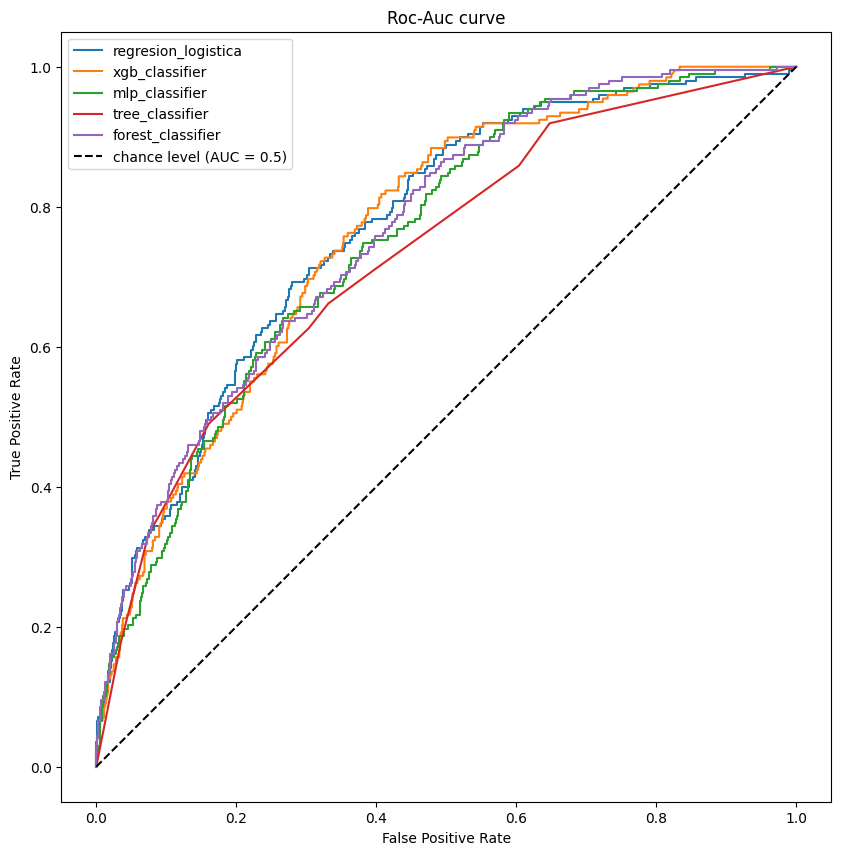

In [161]:

fig = plt.figure(figsize = (10,10))

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(fpr,tpr,label = "regresion_logistica")

fpr, tpr, _ = roc_curve(y_test, modelo_xgb["xgb_classifier"]["parametros"].predict_proba(X_test[features])[:,1])
plt.plot(fpr,tpr,label = "xgb_classifier")

fpr, tpr, _ = roc_curve(y_test, model_mlp["mlp_classifier"]["parametros"].predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(fpr,tpr,label = "mlp_classifier")

fpr, tpr, _ = roc_curve(y_test, modelo_decision_tree["tree_classifier"]["parametros"].predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(fpr,tpr,label = "tree_classifier")

fpr, tpr, _ = roc_curve(y_test, modelo_decision_tree["forest_classifier"]["parametros"].predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(fpr,tpr,label = "forest_classifier")

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Roc-Auc curve")
plt.legend()
plt.show()


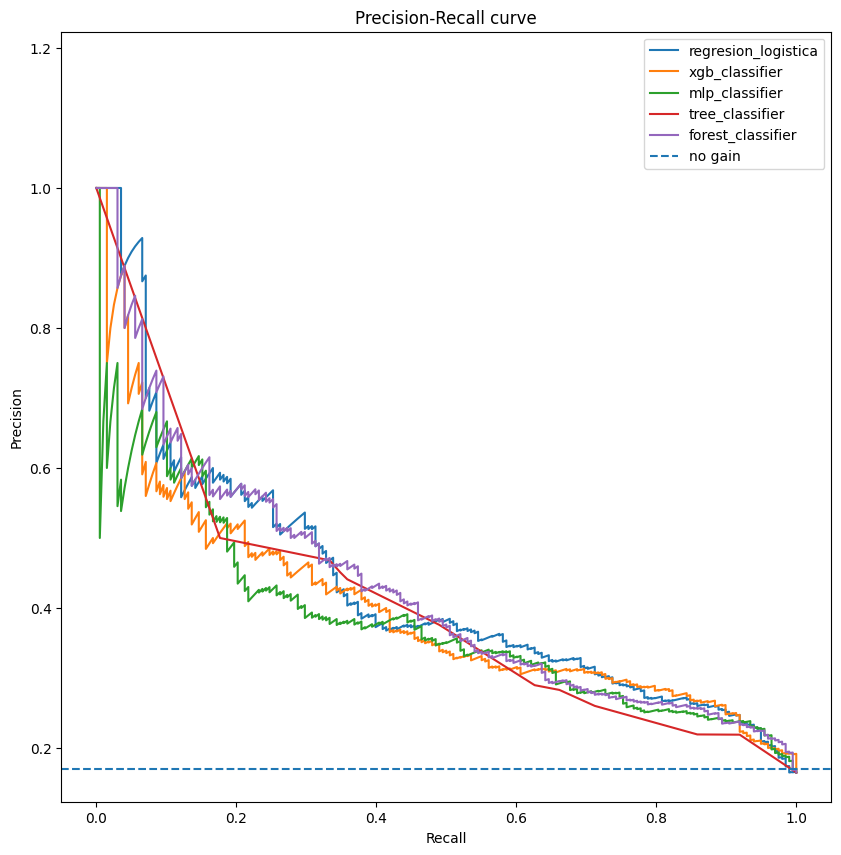

In [205]:


fig = plt.figure(figsize = (10,10))

prec, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(recall,prec,label = "regresion_logistica")

prec, recall, _ = precision_recall_curve(y_test, modelo_xgb["xgb_classifier"]["parametros"].predict_proba(X_test[features])[:,1])
plt.plot(recall,prec,label = "xgb_classifier")

prec, recall, _ = precision_recall_curve(y_test, model_mlp["mlp_classifier"]["parametros"].predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(recall,prec,label = "mlp_classifier")

prec, recall, _ = precision_recall_curve(y_test, modelo_decision_tree["tree_classifier"]["parametros"].predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(recall,prec,label = "tree_classifier")

prec, recall, _ = precision_recall_curve(y_test, modelo_decision_tree["forest_classifier"]["parametros"].predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1])
plt.plot(recall,prec,label = "forest_classifier")


plt.axhline(y_train.target.mean(),  label="no gain",linestyle="--")


plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.show()




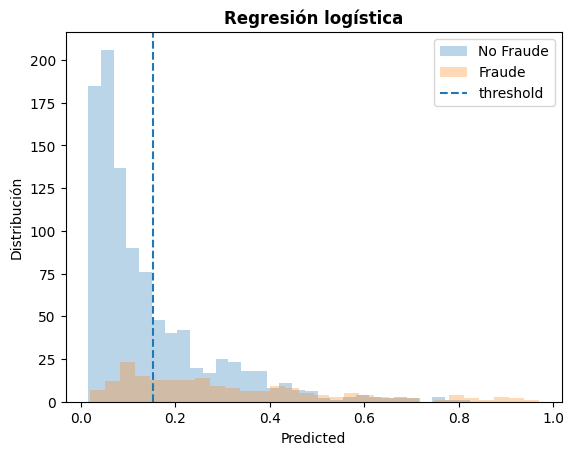

In [164]:
fig, ax = plt.subplots()
ax.hist(model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1][y_test.target==0],alpha=0.3,label = "No Fraude",density= False,bins = 30)
ax.hist(model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1][y_test.target==1],alpha=0.3, label = "Fraude",density= False,bins = 30)
plt.axvline(0.151672,  label="threshold",linestyle="--")
ax.set_title('Regresión logística',fontweight="bold")
ax.set_xlabel("Predicted")
ax.set_ylabel("Distribución")
ax.legend()
plt.show()

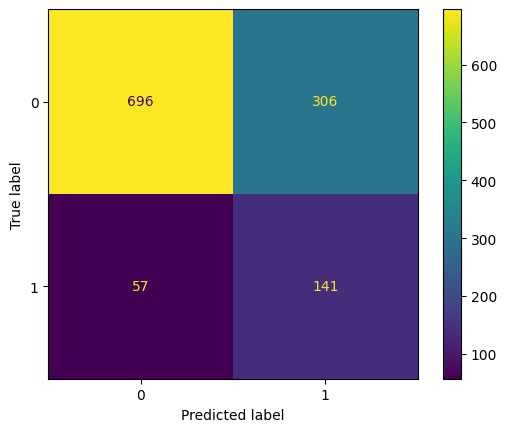

In [222]:
ConfusionMatrixDisplay(confusion_matrix(y_test.target, model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1]>=0.1517)).plot();

In [224]:
recall_score(y_test.target, model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1]>=0.1517)

0.7121212121212122

In [225]:
precision_score(y_test.target, model.predict_proba(X_test[features].fillna({"diff_hours_max":X_train.diff_hours_max.mean()}))[:,1]>=0.1517)

0.31543624161073824